In [1]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

from common.layers import NoisyLinear
from common.replay_buffer import ReplayBuffer
import gym_Aircraft

from itertools import count
import time
import itertools
import matplotlib
import matplotlib.pyplot as plt

In [2]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

In [3]:
env_id = "acav-v0"
env = gym.make(env_id)

/home/jupyter-kunwoopark/.local/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
class RainbowDQN(nn.Module):
    def __init__(self, num_inputs, num_actions, num_atoms, Vmin, Vmax):
        super(RainbowDQN, self).__init__()
        
        self.num_inputs   = num_inputs
        self.num_actions  = num_actions
        self.num_atoms    = num_atoms
        self.Vmin         = Vmin
        self.Vmax         = Vmax
        
        self.linear1 = nn.Linear(num_inputs, 32)
        self.linear2 = nn.Linear(32, 64)
        
        self.noisy_value1 = NoisyLinear(64, 64, use_cuda=USE_CUDA)
        self.noisy_value2 = NoisyLinear(64, self.num_atoms, use_cuda=USE_CUDA)
        
        self.noisy_advantage1 = NoisyLinear(64, 64, use_cuda=USE_CUDA)
        self.noisy_advantage2 = NoisyLinear(64, self.num_atoms * self.num_actions, use_cuda=USE_CUDA)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        
        value = F.relu(self.noisy_value1(x))
        value = self.noisy_value2(value)
        
        advantage = F.relu(self.noisy_advantage1(x))
        advantage = self.noisy_advantage2(advantage)
        
        value     = value.view(batch_size, 1, self.num_atoms)
        advantage = advantage.view(batch_size, self.num_actions, self.num_atoms)
        
        x = value + advantage - advantage.mean(1, keepdim=True)
        x = F.softmax(x.view(-1, self.num_atoms)).view(-1, self.num_actions, self.num_atoms)
        
        return x
        
    def reset_noise(self):
        self.noisy_value1.reset_noise()
        self.noisy_value2.reset_noise()
        self.noisy_advantage1.reset_noise()
        self.noisy_advantage2.reset_noise()
    
    def act(self, state):
        state = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
        dist = self.forward(state).data.cpu()
        dist = dist * torch.linspace(self.Vmin, self.Vmax, self.num_atoms)
        action = dist.sum(2).max(1)[1].numpy()[0]
        return action

In [5]:
num_atoms = 51
Vmin = -10
Vmax = 10

current_model = RainbowDQN(env.observation_space.shape[0], env.action_space.n, num_atoms, Vmin, Vmax)
target_model  = RainbowDQN(env.observation_space.shape[0], env.action_space.n, num_atoms, Vmin, Vmax)

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters(), 0.001)

replay_buffer = ReplayBuffer(10000)

In [6]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())
    
update_target(current_model, target_model)

In [7]:
def projection_distribution(next_state, rewards, dones):
    batch_size  = next_state.size(0)
    
    delta_z = float(Vmax - Vmin) / (num_atoms - 1)
    support = torch.linspace(Vmin, Vmax, num_atoms)
    
    next_dist   = target_model(next_state).data.cpu() * support
    next_action = next_dist.sum(2).max(1)[1]
    next_action = next_action.unsqueeze(1).unsqueeze(1).expand(next_dist.size(0), 1, next_dist.size(2))
    next_dist   = next_dist.gather(1, next_action).squeeze(1)
        
    rewards = rewards.unsqueeze(1).expand_as(next_dist)
    dones   = dones.unsqueeze(1).expand_as(next_dist)
    support = support.unsqueeze(0).expand_as(next_dist)
    
    Tz = rewards + (1 - dones) * 0.99 * support
    Tz = Tz.clamp(min=Vmin, max=Vmax)
    b  = (Tz - Vmin) / delta_z
    l  = b.floor().long()
    u  = b.ceil().long()
        
    offset = torch.linspace(0, (batch_size - 1) * num_atoms, batch_size).long()\
                    .unsqueeze(1).expand(batch_size, num_atoms)

    proj_dist = torch.zeros(next_dist.size())    
    proj_dist.view(-1).index_add_(0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1))
    proj_dist.view(-1).index_add_(0, (u + offset).view(-1), (next_dist * (b - l.float())).view(-1))
        
    return proj_dist

In [8]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size) 

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
    action     = Variable(torch.LongTensor(action))
    reward     = torch.FloatTensor(reward)
    done       = torch.FloatTensor(np.float32(done))

    proj_dist = projection_distribution(next_state, reward, done)
    
    dist = current_model(state)
    action = action.unsqueeze(1).unsqueeze(1).expand(batch_size, 1, num_atoms)
    dist = dist.gather(1, action).squeeze(1)
    dist.data.clamp_(0.01, 0.99)
    loss = -(Variable(proj_dist) * dist.log()).sum(1)
    loss  = loss.mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    current_model.reset_noise()
    target_model.reset_noise()
    
    return loss

In [9]:
num_episodes = 10000
batch_size = 32
gamma=0.99
TARGET_UPDATE=10

losses = []
total_res=[]
reward_list=[]
for i_episode in range(num_episodes):
    total_reward=0
    
    # 환경과 상태 초기화
    res_list=np.zeros(11)
    state = env.reset()

    for t in count():
        # 행동 선택과 수행
        
        action = current_model.act(state)
        
        next_state, reward, done, res = env.step(action)
        
        # 메모리에 변이 저장
        replay_buffer.push(state, action, reward, next_state, done)
        

        # 새로운 상태 관찰
        if not done:
            next_state = next_state
        else:
            next_state = None

        

        # 다음 상태로 이동
        state = next_state

     
        # Data save
        
        cmd_list,r_list,elev_list,azim_list,Pm_list,Pt_list,h_list=res
        Pm_list=Pm_list.tolist()
        Pt_list=Pt_list.tolist()
        merged_data=itertools.chain([cmd_list],[r_list],[elev_list],[azim_list],Pm_list,Pt_list,[h_list])
        merged_data=np.array(list(merged_data))
        res_list=np.vstack([res_list,merged_data])
        
        total_reward+=reward
        
        if done:
            res_list=np.delete(res_list,0,0)
            
            total_res.append(res_list)
            reward_list.append(total_reward)
            
            now = time.localtime()
            print ("%04d/%02d/%02d %02d:%02d:%02d" % (now.tm_year, now.tm_mon, now.tm_mday, now.tm_hour, now.tm_min, now.tm_sec))
            print("episode : {} | final step : {} | total reward : {}".format(i_episode, t, total_reward))
            break
        if len(replay_buffer) > batch_size:
            loss = compute_td_loss(batch_size)
            losses.append(loss.item())
            
        
    #목표 네트워크 업데이트, 모든 웨이트와 바이어스 복사
    if i_episode % TARGET_UPDATE == 0:
        update_target(current_model, target_model)

print('Complete')
env.close()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


2020/10/02 22:40:17
episode : 0 | final step : 198 | total reward : 0
2020/10/02 22:40:19
episode : 1 | final step : 196 | total reward : 71.88871232844828
2020/10/02 22:40:20
episode : 2 | final step : 199 | total reward : 97.01089620175209
2020/10/02 22:40:22
episode : 3 | final step : 199 | total reward : 72.90393729925663
2020/10/02 22:40:24
episode : 4 | final step : 200 | total reward : 93.96192511689983
2020/10/02 22:40:25
episode : 5 | final step : 198 | total reward : 76.34118625853526
2020/10/02 22:40:27
episode : 6 | final step : 194 | total reward : 77.40025065086996
2020/10/02 22:40:28
episode : 7 | final step : 195 | total reward : 80.70272464901014
2020/10/02 22:40:30
episode : 8 | final step : 200 | total reward : 84.71034448177534
2020/10/02 22:40:32
episode : 9 | final step : 200 | total reward : 89.74454592890743
2020/10/02 22:40:33
episode : 10 | final step : 200 | total reward : 81.55575757884384
2020/10/02 22:40:35
episode : 11 | final step : 190 | total reward : 

2020/10/02 22:42:51
episode : 95 | final step : 201 | total reward : 68.85414431577667
2020/10/02 22:42:53
episode : 96 | final step : 195 | total reward : 75.5314516656665
2020/10/02 22:42:54
episode : 97 | final step : 196 | total reward : 76.40690639393716
2020/10/02 22:42:56
episode : 98 | final step : 200 | total reward : 0
2020/10/02 22:42:57
episode : 99 | final step : 198 | total reward : 80.96482142948577
2020/10/02 22:42:59
episode : 100 | final step : 194 | total reward : 79.83710324014643
2020/10/02 22:43:01
episode : 101 | final step : 199 | total reward : 88.99733722676581
2020/10/02 22:43:03
episode : 102 | final step : 200 | total reward : 99.70330548012872
2020/10/02 22:43:04
episode : 103 | final step : 193 | total reward : 70.19121592809488
2020/10/02 22:43:06
episode : 104 | final step : 189 | total reward : 54.597614114611524
2020/10/02 22:43:07
episode : 105 | final step : 199 | total reward : 80.69676204135415
2020/10/02 22:43:09
episode : 106 | final step : 196 

2020/10/02 22:45:24
episode : 189 | final step : 194 | total reward : 73.17357975390424
2020/10/02 22:45:25
episode : 190 | final step : 196 | total reward : 88.75312640371347
2020/10/02 22:45:27
episode : 191 | final step : 199 | total reward : 96.57167366841288
2020/10/02 22:45:29
episode : 192 | final step : 199 | total reward : 89.99339190918113
2020/10/02 22:45:30
episode : 193 | final step : 198 | total reward : 0
2020/10/02 22:45:32
episode : 194 | final step : 197 | total reward : 63.50074110637456
2020/10/02 22:45:33
episode : 195 | final step : 197 | total reward : 81.36094051386803
2020/10/02 22:45:35
episode : 196 | final step : 201 | total reward : 70.00689302557797
2020/10/02 22:45:36
episode : 197 | final step : 196 | total reward : 61.48040620446405
2020/10/02 22:45:38
episode : 198 | final step : 191 | total reward : 64.65023285859475
2020/10/02 22:45:39
episode : 199 | final step : 194 | total reward : 53.857550382046476
2020/10/02 22:45:41
episode : 200 | final step 

2020/10/02 22:47:47
episode : 283 | final step : 199 | total reward : 87.0968182942168
2020/10/02 22:47:49
episode : 284 | final step : 193 | total reward : 70.56574448082264
2020/10/02 22:47:50
episode : 285 | final step : 194 | total reward : 56.676824607964384
2020/10/02 22:47:51
episode : 286 | final step : 199 | total reward : 90.90412098697892
2020/10/02 22:47:53
episode : 287 | final step : 196 | total reward : 72.65440820182626
2020/10/02 22:47:54
episode : 288 | final step : 200 | total reward : 93.4797789726202
2020/10/02 22:47:56
episode : 289 | final step : 197 | total reward : 82.78726489027198
2020/10/02 22:47:57
episode : 290 | final step : 195 | total reward : 61.35703229730203
2020/10/02 22:47:59
episode : 291 | final step : 197 | total reward : 72.74114672158825
2020/10/02 22:48:00
episode : 292 | final step : 196 | total reward : 74.6900793213315
2020/10/02 22:48:02
episode : 293 | final step : 200 | total reward : 99.08632596029473
2020/10/02 22:48:03
episode : 294 

2020/10/02 22:50:12
episode : 377 | final step : 193 | total reward : 70.44313331231578
2020/10/02 22:50:14
episode : 378 | final step : 199 | total reward : 87.0164929346911
2020/10/02 22:50:15
episode : 379 | final step : 196 | total reward : 80.263047236849
2020/10/02 22:50:17
episode : 380 | final step : 198 | total reward : 79.23753376671
2020/10/02 22:50:19
episode : 381 | final step : 190 | total reward : 58.257584850367934
2020/10/02 22:50:21
episode : 382 | final step : 200 | total reward : 0
2020/10/02 22:50:22
episode : 383 | final step : 196 | total reward : 83.74803804795779
2020/10/02 22:50:24
episode : 384 | final step : 199 | total reward : 88.61666395928363
2020/10/02 22:50:25
episode : 385 | final step : 196 | total reward : 78.34299890529847
2020/10/02 22:50:27
episode : 386 | final step : 200 | total reward : 93.50966186957707
2020/10/02 22:50:29
episode : 387 | final step : 194 | total reward : 71.7811445986911
2020/10/02 22:50:30
episode : 388 | final step : 199 |

2020/10/02 22:52:43
episode : 471 | final step : 194 | total reward : 72.70540509019203
2020/10/02 22:52:44
episode : 472 | final step : 198 | total reward : 89.78411809224338
2020/10/02 22:52:46
episode : 473 | final step : 199 | total reward : 83.24015542063029
2020/10/02 22:52:47
episode : 474 | final step : 194 | total reward : 62.88447830219005
2020/10/02 22:52:49
episode : 475 | final step : 200 | total reward : 89.55278023904377
2020/10/02 22:52:51
episode : 476 | final step : 193 | total reward : 69.94839060547784
2020/10/02 22:52:52
episode : 477 | final step : 196 | total reward : 76.79402043137776
2020/10/02 22:52:54
episode : 478 | final step : 194 | total reward : 79.15738357192454
2020/10/02 22:52:56
episode : 479 | final step : 199 | total reward : 92.95155076593649
2020/10/02 22:52:57
episode : 480 | final step : 199 | total reward : 83.21711485450717
2020/10/02 22:52:59
episode : 481 | final step : 194 | total reward : 77.32722540196677
2020/10/02 22:53:00
episode : 48

2020/10/02 22:55:13
episode : 565 | final step : 198 | total reward : 84.6714298802231
2020/10/02 22:55:15
episode : 566 | final step : 190 | total reward : 60.2271385100786
2020/10/02 22:55:16
episode : 567 | final step : 193 | total reward : 67.36464660885719
2020/10/02 22:55:18
episode : 568 | final step : 194 | total reward : 62.258132754688724
2020/10/02 22:55:20
episode : 569 | final step : 200 | total reward : 92.56260828982444
2020/10/02 22:55:21
episode : 570 | final step : 197 | total reward : 79.66782499093189
2020/10/02 22:55:23
episode : 571 | final step : 198 | total reward : 88.99175631315434
2020/10/02 22:55:24
episode : 572 | final step : 197 | total reward : 87.82922354026685
2020/10/02 22:55:26
episode : 573 | final step : 200 | total reward : 91.01587199195787
2020/10/02 22:55:28
episode : 574 | final step : 198 | total reward : 91.88608600440914
2020/10/02 22:55:29
episode : 575 | final step : 196 | total reward : 81.7137703335507
2020/10/02 22:55:31
episode : 576 

2020/10/02 22:57:48
episode : 659 | final step : 200 | total reward : 94.42250134958013
2020/10/02 22:57:50
episode : 660 | final step : 200 | total reward : 90.7278478579545
2020/10/02 22:57:52
episode : 661 | final step : 191 | total reward : 62.53172521655882
2020/10/02 22:57:54
episode : 662 | final step : 193 | total reward : 62.95866864139574
2020/10/02 22:57:55
episode : 663 | final step : 198 | total reward : 80.06852716689659
2020/10/02 22:57:57
episode : 664 | final step : 200 | total reward : 88.24213353315925
2020/10/02 22:57:59
episode : 665 | final step : 200 | total reward : 97.11741277599428
2020/10/02 22:58:01
episode : 666 | final step : 200 | total reward : 97.16408471894361
2020/10/02 22:58:02
episode : 667 | final step : 191 | total reward : 61.66054840342609
2020/10/02 22:58:04
episode : 668 | final step : 197 | total reward : 89.42668268595155
2020/10/02 22:58:05
episode : 669 | final step : 192 | total reward : 66.95576382834778
2020/10/02 22:58:07
episode : 670

2020/10/02 23:00:25
episode : 753 | final step : 202 | total reward : 68.04715834792027
2020/10/02 23:00:27
episode : 754 | final step : 200 | total reward : 91.50312308529408
2020/10/02 23:00:28
episode : 755 | final step : 200 | total reward : 92.49045116829227
2020/10/02 23:00:30
episode : 756 | final step : 195 | total reward : 76.19466655276489
2020/10/02 23:00:32
episode : 757 | final step : 199 | total reward : 87.60444869513557
2020/10/02 23:00:34
episode : 758 | final step : 198 | total reward : 69.06744896174399
2020/10/02 23:00:35
episode : 759 | final step : 195 | total reward : 69.31630210926525
2020/10/02 23:00:37
episode : 760 | final step : 200 | total reward : 99.45049474322697
2020/10/02 23:00:38
episode : 761 | final step : 198 | total reward : 88.33103133035972
2020/10/02 23:00:40
episode : 762 | final step : 192 | total reward : 66.62763813705908
2020/10/02 23:00:42
episode : 763 | final step : 199 | total reward : 87.49374319698452
2020/10/02 23:00:43
episode : 76

2020/10/02 23:03:02
episode : 847 | final step : 193 | total reward : 66.38118551651647
2020/10/02 23:03:04
episode : 848 | final step : 198 | total reward : 84.67472789367822
2020/10/02 23:03:05
episode : 849 | final step : 197 | total reward : 80.47275385915667
2020/10/02 23:03:07
episode : 850 | final step : 200 | total reward : 98.29233911175723
2020/10/02 23:03:08
episode : 851 | final step : 199 | total reward : 0
2020/10/02 23:03:10
episode : 852 | final step : 199 | total reward : 81.383152606135
2020/10/02 23:03:12
episode : 853 | final step : 199 | total reward : 84.41047179805076
2020/10/02 23:03:13
episode : 854 | final step : 195 | total reward : 80.06998357810643
2020/10/02 23:03:15
episode : 855 | final step : 193 | total reward : 58.36224066922363
2020/10/02 23:03:17
episode : 856 | final step : 200 | total reward : 91.68291876734078
2020/10/02 23:03:18
episode : 857 | final step : 199 | total reward : 76.13022547997035
2020/10/02 23:03:20
episode : 858 | final step : 1

2020/10/02 23:05:40
episode : 942 | final step : 199 | total reward : 84.77744237686635
2020/10/02 23:05:42
episode : 943 | final step : 199 | total reward : 87.07090234207732
2020/10/02 23:05:44
episode : 944 | final step : 200 | total reward : 84.3885832135256
2020/10/02 23:05:45
episode : 945 | final step : 195 | total reward : 65.54155303246134
2020/10/02 23:05:47
episode : 946 | final step : 191 | total reward : 64.72590978860565
2020/10/02 23:05:48
episode : 947 | final step : 196 | total reward : 80.17176008838955
2020/10/02 23:05:50
episode : 948 | final step : 200 | total reward : 97.53863936338816
2020/10/02 23:05:52
episode : 949 | final step : 197 | total reward : 89.04941711930081
2020/10/02 23:05:53
episode : 950 | final step : 197 | total reward : 76.72649087648213
2020/10/02 23:05:55
episode : 951 | final step : 200 | total reward : 99.81346970151361
2020/10/02 23:05:57
episode : 952 | final step : 197 | total reward : 86.79258741790879
2020/10/02 23:05:58
episode : 953

2020/10/02 23:08:16
episode : 1036 | final step : 197 | total reward : 74.1623248877458
2020/10/02 23:08:17
episode : 1037 | final step : 197 | total reward : 88.23867325176492
2020/10/02 23:08:19
episode : 1038 | final step : 199 | total reward : 91.16187149212789
2020/10/02 23:08:20
episode : 1039 | final step : 199 | total reward : 93.32655953537365
2020/10/02 23:08:22
episode : 1040 | final step : 194 | total reward : 73.82131481823927
2020/10/02 23:08:23
episode : 1041 | final step : 197 | total reward : 84.68843169322798
2020/10/02 23:08:25
episode : 1042 | final step : 197 | total reward : 84.43821191441378
2020/10/02 23:08:26
episode : 1043 | final step : 194 | total reward : 70.74764869608619
2020/10/02 23:08:28
episode : 1044 | final step : 194 | total reward : 76.19948312861048
2020/10/02 23:08:29
episode : 1045 | final step : 198 | total reward : 92.0937995274806
2020/10/02 23:08:31
episode : 1046 | final step : 195 | total reward : 84.65159686168442
2020/10/02 23:08:33
epi

2020/10/02 23:10:42
episode : 1129 | final step : 199 | total reward : 83.58297648164995
2020/10/02 23:10:44
episode : 1130 | final step : 202 | total reward : 58.272594217487274
2020/10/02 23:10:46
episode : 1131 | final step : 199 | total reward : 90.15582365364675
2020/10/02 23:10:47
episode : 1132 | final step : 197 | total reward : 80.59935037001888
2020/10/02 23:10:49
episode : 1133 | final step : 194 | total reward : 70.8515298224672
2020/10/02 23:10:50
episode : 1134 | final step : 194 | total reward : 69.51138406135779
2020/10/02 23:10:52
episode : 1135 | final step : 198 | total reward : 88.9438390768884
2020/10/02 23:10:53
episode : 1136 | final step : 196 | total reward : 82.35815880229168
2020/10/02 23:10:55
episode : 1137 | final step : 197 | total reward : 85.00445697755453
2020/10/02 23:10:57
episode : 1138 | final step : 197 | total reward : 82.03869300416424
2020/10/02 23:10:58
episode : 1139 | final step : 199 | total reward : 93.9401213381117
2020/10/02 23:11:00
epi

2020/10/02 23:13:08
episode : 1222 | final step : 199 | total reward : 92.93147071776977
2020/10/02 23:13:10
episode : 1223 | final step : 195 | total reward : 77.7491950525073
2020/10/02 23:13:11
episode : 1224 | final step : 193 | total reward : 70.16632108981598
2020/10/02 23:13:13
episode : 1225 | final step : 196 | total reward : 63.23626072307649
2020/10/02 23:13:14
episode : 1226 | final step : 199 | total reward : 85.9932081674386
2020/10/02 23:13:16
episode : 1227 | final step : 197 | total reward : 65.1574201765401
2020/10/02 23:13:17
episode : 1228 | final step : 196 | total reward : 80.55711687480236
2020/10/02 23:13:19
episode : 1229 | final step : 195 | total reward : 86.42476544793729
2020/10/02 23:13:20
episode : 1230 | final step : 200 | total reward : 92.52946905153783
2020/10/02 23:13:22
episode : 1231 | final step : 196 | total reward : 79.82612155163287
2020/10/02 23:13:23
episode : 1232 | final step : 200 | total reward : 94.19374042545722
2020/10/02 23:13:25
epis

2020/10/02 23:15:32
episode : 1315 | final step : 200 | total reward : 84.96686213957715
2020/10/02 23:15:34
episode : 1316 | final step : 200 | total reward : 89.05421063469726
2020/10/02 23:15:35
episode : 1317 | final step : 194 | total reward : 68.45490493083803
2020/10/02 23:15:37
episode : 1318 | final step : 200 | total reward : 94.92705447715892
2020/10/02 23:15:38
episode : 1319 | final step : 200 | total reward : 79.36503045428157
2020/10/02 23:15:40
episode : 1320 | final step : 200 | total reward : 88.0113794036838
2020/10/02 23:15:41
episode : 1321 | final step : 198 | total reward : 86.78950399999768
2020/10/02 23:15:43
episode : 1322 | final step : 199 | total reward : 92.04730848988793
2020/10/02 23:15:44
episode : 1323 | final step : 195 | total reward : 67.8261167812518
2020/10/02 23:15:46
episode : 1324 | final step : 200 | total reward : 96.40124773710174
2020/10/02 23:15:47
episode : 1325 | final step : 199 | total reward : 91.87232808813984
2020/10/02 23:15:49
epi

2020/10/02 23:17:57
episode : 1408 | final step : 192 | total reward : 65.88326235243716
2020/10/02 23:17:58
episode : 1409 | final step : 199 | total reward : 94.95077344201856
2020/10/02 23:18:00
episode : 1410 | final step : 199 | total reward : 63.874504978801966
2020/10/02 23:18:01
episode : 1411 | final step : 198 | total reward : 0
2020/10/02 23:18:03
episode : 1412 | final step : 200 | total reward : 99.45248048055991
2020/10/02 23:18:04
episode : 1413 | final step : 199 | total reward : 91.5507735866269
2020/10/02 23:18:06
episode : 1414 | final step : 196 | total reward : 69.77975648086665
2020/10/02 23:18:07
episode : 1415 | final step : 197 | total reward : 88.33204422272868
2020/10/02 23:18:09
episode : 1416 | final step : 192 | total reward : 69.41544443967832
2020/10/02 23:18:10
episode : 1417 | final step : 200 | total reward : 92.32642370388842
2020/10/02 23:18:12
episode : 1418 | final step : 196 | total reward : 82.34905323929623
2020/10/02 23:18:13
episode : 1419 | 

2020/10/02 23:20:21
episode : 1501 | final step : 200 | total reward : 98.90971955385075
2020/10/02 23:20:22
episode : 1502 | final step : 199 | total reward : 90.89722127517263
2020/10/02 23:20:24
episode : 1503 | final step : 200 | total reward : 99.82708886456282
2020/10/02 23:20:25
episode : 1504 | final step : 200 | total reward : 82.48218939950121
2020/10/02 23:20:27
episode : 1505 | final step : 195 | total reward : 69.96151411884763
2020/10/02 23:20:29
episode : 1506 | final step : 195 | total reward : 63.87411975716714
2020/10/02 23:20:30
episode : 1507 | final step : 191 | total reward : 65.18855179569894
2020/10/02 23:20:32
episode : 1508 | final step : 200 | total reward : 98.9760916479857
2020/10/02 23:20:33
episode : 1509 | final step : 199 | total reward : 82.18705321876384
2020/10/02 23:20:35
episode : 1510 | final step : 200 | total reward : 99.80375973906436
2020/10/02 23:20:37
episode : 1511 | final step : 200 | total reward : 97.32136169984963
2020/10/02 23:20:38
ep

2020/10/02 23:22:52
episode : 1594 | final step : 196 | total reward : 60.258364855391555
2020/10/02 23:22:53
episode : 1595 | final step : 196 | total reward : 77.63018582489913
2020/10/02 23:22:55
episode : 1596 | final step : 192 | total reward : 69.41640530196156
2020/10/02 23:22:57
episode : 1597 | final step : 200 | total reward : 89.60377242977846
2020/10/02 23:22:58
episode : 1598 | final step : 191 | total reward : 56.34768872532213
2020/10/02 23:23:00
episode : 1599 | final step : 194 | total reward : 68.76878140951767
2020/10/02 23:23:01
episode : 1600 | final step : 199 | total reward : 65.43145412061251
2020/10/02 23:23:03
episode : 1601 | final step : 198 | total reward : 81.61346269858022
2020/10/02 23:23:05
episode : 1602 | final step : 191 | total reward : 65.41958458840374
2020/10/02 23:23:06
episode : 1603 | final step : 197 | total reward : 80.17276681207709
2020/10/02 23:23:08
episode : 1604 | final step : 200 | total reward : 99.58601696792694
2020/10/02 23:23:10


2020/10/02 23:25:19
episode : 1687 | final step : 200 | total reward : 97.63232038149448
2020/10/02 23:25:20
episode : 1688 | final step : 197 | total reward : 88.68411254602857
2020/10/02 23:25:22
episode : 1689 | final step : 200 | total reward : 96.4915197587231
2020/10/02 23:25:24
episode : 1690 | final step : 194 | total reward : 71.26424539573236
2020/10/02 23:25:25
episode : 1691 | final step : 201 | total reward : 69.01016030061889
2020/10/02 23:25:27
episode : 1692 | final step : 194 | total reward : 69.56007077037368
2020/10/02 23:25:29
episode : 1693 | final step : 200 | total reward : 72.23511034404551
2020/10/02 23:25:30
episode : 1694 | final step : 188 | total reward : 52.7270239918806
2020/10/02 23:25:32
episode : 1695 | final step : 200 | total reward : 0
2020/10/02 23:25:33
episode : 1696 | final step : 199 | total reward : 96.01357930599228
2020/10/02 23:25:35
episode : 1697 | final step : 200 | total reward : 65.62739275874952
2020/10/02 23:25:36
episode : 1698 | fi

2020/10/02 23:27:43
episode : 1780 | final step : 199 | total reward : 84.10194283491995
2020/10/02 23:27:45
episode : 1781 | final step : 199 | total reward : 85.74521864824077
2020/10/02 23:27:47
episode : 1782 | final step : 199 | total reward : 93.64519346301967
2020/10/02 23:27:48
episode : 1783 | final step : 197 | total reward : 84.00634999372926
2020/10/02 23:27:50
episode : 1784 | final step : 199 | total reward : 74.14017197848891
2020/10/02 23:27:52
episode : 1785 | final step : 199 | total reward : 95.2555127500252
2020/10/02 23:27:53
episode : 1786 | final step : 194 | total reward : 62.459974674876044
2020/10/02 23:27:55
episode : 1787 | final step : 200 | total reward : 90.0003957197839
2020/10/02 23:27:57
episode : 1788 | final step : 198 | total reward : 82.40183494631535
2020/10/02 23:27:59
episode : 1789 | final step : 194 | total reward : 79.98299654232055
2020/10/02 23:28:00
episode : 1790 | final step : 200 | total reward : 82.29614424013081
2020/10/02 23:28:02
ep

2020/10/02 23:30:20
episode : 1874 | final step : 199 | total reward : 89.0018382468313
2020/10/02 23:30:21
episode : 1875 | final step : 196 | total reward : 89.85185427366626
2020/10/02 23:30:23
episode : 1876 | final step : 196 | total reward : 78.17327063960005
2020/10/02 23:30:25
episode : 1877 | final step : 198 | total reward : 0
2020/10/02 23:30:26
episode : 1878 | final step : 197 | total reward : 83.22954131396149
2020/10/02 23:30:28
episode : 1879 | final step : 193 | total reward : 73.58063653796594
2020/10/02 23:30:30
episode : 1880 | final step : 199 | total reward : 90.99768420408621
2020/10/02 23:30:31
episode : 1881 | final step : 200 | total reward : 88.23034313224971
2020/10/02 23:30:33
episode : 1882 | final step : 198 | total reward : 67.42484572979664
2020/10/02 23:30:34
episode : 1883 | final step : 195 | total reward : 78.42913320697484
2020/10/02 23:30:36
episode : 1884 | final step : 192 | total reward : 67.37430334877037
2020/10/02 23:30:38
episode : 1885 | f

2020/10/02 23:32:49
episode : 1968 | final step : 195 | total reward : 76.62231964288135
2020/10/02 23:32:50
episode : 1969 | final step : 199 | total reward : 64.19273080006008
2020/10/02 23:32:52
episode : 1970 | final step : 200 | total reward : 99.45706326698026
2020/10/02 23:32:53
episode : 1971 | final step : 200 | total reward : 95.99303130595189
2020/10/02 23:32:55
episode : 1972 | final step : 202 | total reward : 72.4029019687955
2020/10/02 23:32:56
episode : 1973 | final step : 200 | total reward : 90.60480177959369
2020/10/02 23:32:58
episode : 1974 | final step : 200 | total reward : 93.05798844897888
2020/10/02 23:32:59
episode : 1975 | final step : 194 | total reward : 77.35951428552207
2020/10/02 23:33:01
episode : 1976 | final step : 197 | total reward : 76.75009094956367
2020/10/02 23:33:03
episode : 1977 | final step : 198 | total reward : 81.58740394316541
2020/10/02 23:33:04
episode : 1978 | final step : 200 | total reward : 0
2020/10/02 23:33:06
episode : 1979 | f

2020/10/02 23:35:17
episode : 2061 | final step : 199 | total reward : 97.14293778524384
2020/10/02 23:35:19
episode : 2062 | final step : 200 | total reward : 85.25006633488225
2020/10/02 23:35:20
episode : 2063 | final step : 200 | total reward : 93.58382845829327
2020/10/02 23:35:22
episode : 2064 | final step : 197 | total reward : 72.20932376910048
2020/10/02 23:35:24
episode : 2065 | final step : 200 | total reward : 95.55025738271814
2020/10/02 23:35:26
episode : 2066 | final step : 197 | total reward : 78.9472066699575
2020/10/02 23:35:28
episode : 2067 | final step : 197 | total reward : 83.49048170548492
2020/10/02 23:35:29
episode : 2068 | final step : 198 | total reward : 76.27165205961143
2020/10/02 23:35:31
episode : 2069 | final step : 197 | total reward : 84.83105007625034
2020/10/02 23:35:32
episode : 2070 | final step : 194 | total reward : 72.5286812453708
2020/10/02 23:35:34
episode : 2071 | final step : 198 | total reward : 72.61924353585356
2020/10/02 23:35:35
epi

2020/10/02 23:37:54
episode : 2154 | final step : 199 | total reward : 88.65419481982092
2020/10/02 23:37:56
episode : 2155 | final step : 199 | total reward : 97.37332701353397
2020/10/02 23:37:57
episode : 2156 | final step : 199 | total reward : 87.39037746529785
2020/10/02 23:37:59
episode : 2157 | final step : 195 | total reward : 81.48592094447989
2020/10/02 23:38:00
episode : 2158 | final step : 193 | total reward : 65.85407972330482
2020/10/02 23:38:02
episode : 2159 | final step : 190 | total reward : 61.82395930332945
2020/10/02 23:38:04
episode : 2160 | final step : 199 | total reward : 88.3121169593419
2020/10/02 23:38:05
episode : 2161 | final step : 199 | total reward : 97.51163174000607
2020/10/02 23:38:07
episode : 2162 | final step : 195 | total reward : 79.41521549255287
2020/10/02 23:38:09
episode : 2163 | final step : 200 | total reward : 89.8326997589924
2020/10/02 23:38:10
episode : 2164 | final step : 199 | total reward : 93.42361675276324
2020/10/02 23:38:12
epi

2020/10/02 23:40:27
episode : 2247 | final step : 197 | total reward : 77.76903050815497
2020/10/02 23:40:28
episode : 2248 | final step : 198 | total reward : 85.69236567731802
2020/10/02 23:40:30
episode : 2249 | final step : 197 | total reward : 84.87473742901062
2020/10/02 23:40:32
episode : 2250 | final step : 198 | total reward : 82.52176615050213
2020/10/02 23:40:33
episode : 2251 | final step : 200 | total reward : 90.79486970006492
2020/10/02 23:40:35
episode : 2252 | final step : 202 | total reward : 71.0655436903477
2020/10/02 23:40:36
episode : 2253 | final step : 199 | total reward : 93.06281192861009
2020/10/02 23:40:38
episode : 2254 | final step : 191 | total reward : 65.24958494837163
2020/10/02 23:40:39
episode : 2255 | final step : 200 | total reward : 86.15630983648533
2020/10/02 23:40:41
episode : 2256 | final step : 199 | total reward : 92.38457120915379
2020/10/02 23:40:42
episode : 2257 | final step : 199 | total reward : 86.50430149571149
2020/10/02 23:40:44
ep

2020/10/02 23:42:53
episode : 2340 | final step : 195 | total reward : 82.94791288184086
2020/10/02 23:42:55
episode : 2341 | final step : 196 | total reward : 85.41287353575662
2020/10/02 23:42:56
episode : 2342 | final step : 198 | total reward : 67.64702769270635
2020/10/02 23:42:58
episode : 2343 | final step : 198 | total reward : 85.8219561976926
2020/10/02 23:43:00
episode : 2344 | final step : 200 | total reward : 93.86968204248524
2020/10/02 23:43:01
episode : 2345 | final step : 193 | total reward : 63.582789857661076
2020/10/02 23:43:03
episode : 2346 | final step : 199 | total reward : 87.93949365104432
2020/10/02 23:43:05
episode : 2347 | final step : 199 | total reward : 98.64651452052797
2020/10/02 23:43:06
episode : 2348 | final step : 198 | total reward : 73.08793897987199
2020/10/02 23:43:08
episode : 2349 | final step : 199 | total reward : 95.13672752501098
2020/10/02 23:43:10
episode : 2350 | final step : 199 | total reward : 89.67355806509292
2020/10/02 23:43:11
e

2020/10/02 23:45:20
episode : 2433 | final step : 198 | total reward : 60.74674086750367
2020/10/02 23:45:21
episode : 2434 | final step : 199 | total reward : 97.38321804620608
2020/10/02 23:45:23
episode : 2435 | final step : 199 | total reward : 93.16044852074326
2020/10/02 23:45:24
episode : 2436 | final step : 193 | total reward : 64.56629542010978
2020/10/02 23:45:26
episode : 2437 | final step : 197 | total reward : 92.19330866465009
2020/10/02 23:45:28
episode : 2438 | final step : 199 | total reward : 75.69566034727849
2020/10/02 23:45:30
episode : 2439 | final step : 200 | total reward : 0
2020/10/02 23:45:31
episode : 2440 | final step : 200 | total reward : 96.66012511061183
2020/10/02 23:45:33
episode : 2441 | final step : 200 | total reward : 87.25537322276426
2020/10/02 23:45:34
episode : 2442 | final step : 199 | total reward : 95.65124441014294
2020/10/02 23:45:36
episode : 2443 | final step : 198 | total reward : 92.45553130018295
2020/10/02 23:45:37
episode : 2444 | 

2020/10/02 23:47:44
episode : 2526 | final step : 199 | total reward : 88.77318091602817
2020/10/02 23:47:46
episode : 2527 | final step : 199 | total reward : 85.29183709689057
2020/10/02 23:47:48
episode : 2528 | final step : 200 | total reward : 89.97829446151731
2020/10/02 23:47:50
episode : 2529 | final step : 196 | total reward : 71.61267804852758
2020/10/02 23:47:51
episode : 2530 | final step : 197 | total reward : 86.81868669755391
2020/10/02 23:47:53
episode : 2531 | final step : 198 | total reward : 85.55794677244215
2020/10/02 23:47:54
episode : 2532 | final step : 195 | total reward : 81.9279631341988
2020/10/02 23:47:56
episode : 2533 | final step : 195 | total reward : 80.19810568221669
2020/10/02 23:47:57
episode : 2534 | final step : 198 | total reward : 83.19604963965747
2020/10/02 23:47:59
episode : 2535 | final step : 200 | total reward : 97.2625442651319
2020/10/02 23:48:00
episode : 2536 | final step : 196 | total reward : 69.91505173419502
2020/10/02 23:48:02
epi

2020/10/02 23:50:10
episode : 2619 | final step : 198 | total reward : 72.52852834130772
2020/10/02 23:50:11
episode : 2620 | final step : 200 | total reward : 91.18414902491864
2020/10/02 23:50:13
episode : 2621 | final step : 196 | total reward : 81.03278389116018
2020/10/02 23:50:15
episode : 2622 | final step : 195 | total reward : 76.7024989856968
2020/10/02 23:50:16
episode : 2623 | final step : 200 | total reward : 78.45789577968796
2020/10/02 23:50:18
episode : 2624 | final step : 192 | total reward : 67.18657066106938
2020/10/02 23:50:19
episode : 2625 | final step : 199 | total reward : 90.57526355229751
2020/10/02 23:50:21
episode : 2626 | final step : 198 | total reward : 77.39414888060192
2020/10/02 23:50:22
episode : 2627 | final step : 194 | total reward : 73.36998981343785
2020/10/02 23:50:24
episode : 2628 | final step : 200 | total reward : 88.38414760163516
2020/10/02 23:50:25
episode : 2629 | final step : 198 | total reward : 82.47344921152671
2020/10/02 23:50:27
ep

2020/10/02 23:52:39
episode : 2712 | final step : 198 | total reward : 87.95790724327263
2020/10/02 23:52:40
episode : 2713 | final step : 198 | total reward : 93.09606694018372
2020/10/02 23:52:42
episode : 2714 | final step : 198 | total reward : 88.97393802041499
2020/10/02 23:52:44
episode : 2715 | final step : 199 | total reward : 92.84862469212686
2020/10/02 23:52:45
episode : 2716 | final step : 198 | total reward : 84.75876540234894
2020/10/02 23:52:47
episode : 2717 | final step : 199 | total reward : 0
2020/10/02 23:52:49
episode : 2718 | final step : 196 | total reward : 63.14572975891515
2020/10/02 23:52:50
episode : 2719 | final step : 200 | total reward : 77.29300916231266
2020/10/02 23:52:52
episode : 2720 | final step : 193 | total reward : 66.07623664922808
2020/10/02 23:52:53
episode : 2721 | final step : 200 | total reward : 87.10865096177058
2020/10/02 23:52:55
episode : 2722 | final step : 190 | total reward : 61.12286959599628
2020/10/02 23:52:56
episode : 2723 | 

2020/10/02 23:55:12
episode : 2805 | final step : 200 | total reward : 93.48687704064793
2020/10/02 23:55:14
episode : 2806 | final step : 191 | total reward : 65.61293642731336
2020/10/02 23:55:15
episode : 2807 | final step : 198 | total reward : 93.57916159980144
2020/10/02 23:55:17
episode : 2808 | final step : 194 | total reward : 76.21107488242193
2020/10/02 23:55:19
episode : 2809 | final step : 195 | total reward : 62.401927714982406
2020/10/02 23:55:20
episode : 2810 | final step : 195 | total reward : 83.98284415702283
2020/10/02 23:55:22
episode : 2811 | final step : 196 | total reward : 79.38399528101256
2020/10/02 23:55:24
episode : 2812 | final step : 194 | total reward : 76.26568904716044
2020/10/02 23:55:25
episode : 2813 | final step : 200 | total reward : 82.7397187108718
2020/10/02 23:55:27
episode : 2814 | final step : 200 | total reward : 90.70123702389763
2020/10/02 23:55:29
episode : 2815 | final step : 198 | total reward : 97.70505921531435
2020/10/02 23:55:30
e

2020/10/02 23:57:44
episode : 2898 | final step : 201 | total reward : 64.38138543837542
2020/10/02 23:57:46
episode : 2899 | final step : 200 | total reward : 90.71460138649229
2020/10/02 23:57:48
episode : 2900 | final step : 195 | total reward : 74.46841595008418
2020/10/02 23:57:50
episode : 2901 | final step : 196 | total reward : 76.57560597898235
2020/10/02 23:57:51
episode : 2902 | final step : 199 | total reward : 66.2335985581779
2020/10/02 23:57:53
episode : 2903 | final step : 191 | total reward : 63.93748126835347
2020/10/02 23:57:54
episode : 2904 | final step : 198 | total reward : 87.67229143873155
2020/10/02 23:57:56
episode : 2905 | final step : 192 | total reward : 65.70408696881385
2020/10/02 23:57:58
episode : 2906 | final step : 199 | total reward : 63.682297241290435
2020/10/02 23:58:00
episode : 2907 | final step : 200 | total reward : 0
2020/10/02 23:58:01
episode : 2908 | final step : 198 | total reward : 91.94097643544855
2020/10/02 23:58:03
episode : 2909 | 

2020/10/03 00:00:24
episode : 2991 | final step : 199 | total reward : 89.86873398390458
2020/10/03 00:00:25
episode : 2992 | final step : 191 | total reward : 54.44479012917153
2020/10/03 00:00:27
episode : 2993 | final step : 200 | total reward : 95.1566564572569
2020/10/03 00:00:28
episode : 2994 | final step : 199 | total reward : 87.75511430584486
2020/10/03 00:00:30
episode : 2995 | final step : 194 | total reward : 62.62205285378213
2020/10/03 00:00:32
episode : 2996 | final step : 199 | total reward : 87.76793384420193
2020/10/03 00:00:33
episode : 2997 | final step : 195 | total reward : 65.68045529014874
2020/10/03 00:00:35
episode : 2998 | final step : 200 | total reward : 85.26575524258413
2020/10/03 00:00:37
episode : 2999 | final step : 196 | total reward : 75.58834559066396
2020/10/03 00:00:38
episode : 3000 | final step : 194 | total reward : 70.20893067729526
2020/10/03 00:00:40
episode : 3001 | final step : 198 | total reward : 88.04406683209123
2020/10/03 00:00:41
ep

2020/10/03 00:02:51
episode : 3084 | final step : 200 | total reward : 0
2020/10/03 00:02:53
episode : 3085 | final step : 199 | total reward : 75.42443211163118
2020/10/03 00:02:55
episode : 3086 | final step : 192 | total reward : 69.42504565400871
2020/10/03 00:02:56
episode : 3087 | final step : 199 | total reward : 85.70961860299262
2020/10/03 00:02:58
episode : 3088 | final step : 199 | total reward : 99.34396964572954
2020/10/03 00:02:59
episode : 3089 | final step : 200 | total reward : 89.02044683842253
2020/10/03 00:03:01
episode : 3090 | final step : 192 | total reward : 68.10004232973903
2020/10/03 00:03:03
episode : 3091 | final step : 202 | total reward : 87.4905919206672
2020/10/03 00:03:05
episode : 3092 | final step : 196 | total reward : 87.08094821717873
2020/10/03 00:03:06
episode : 3093 | final step : 191 | total reward : 58.44396606948441
2020/10/03 00:03:08
episode : 3094 | final step : 200 | total reward : 87.80282791314076
2020/10/03 00:03:09
episode : 3095 | f

2020/10/03 00:05:17
episode : 3177 | final step : 195 | total reward : 66.42776902686052
2020/10/03 00:05:19
episode : 3178 | final step : 199 | total reward : 94.58438388982684
2020/10/03 00:05:21
episode : 3179 | final step : 200 | total reward : 98.73148574074632
2020/10/03 00:05:22
episode : 3180 | final step : 198 | total reward : 70.98122443477978
2020/10/03 00:05:24
episode : 3181 | final step : 199 | total reward : 87.93010307264763
2020/10/03 00:05:26
episode : 3182 | final step : 200 | total reward : 95.44645506603112
2020/10/03 00:05:27
episode : 3183 | final step : 199 | total reward : 85.28241750752942
2020/10/03 00:05:29
episode : 3184 | final step : 196 | total reward : 69.83390527409766
2020/10/03 00:05:30
episode : 3185 | final step : 198 | total reward : 0
2020/10/03 00:05:32
episode : 3186 | final step : 197 | total reward : 94.4591677870435
2020/10/03 00:05:33
episode : 3187 | final step : 200 | total reward : 97.71271149364374
2020/10/03 00:05:35
episode : 3188 | f

2020/10/03 00:07:42
episode : 3270 | final step : 200 | total reward : 92.25147285002305
2020/10/03 00:07:43
episode : 3271 | final step : 199 | total reward : 80.18542598089518
2020/10/03 00:07:45
episode : 3272 | final step : 191 | total reward : 61.04006914255974
2020/10/03 00:07:47
episode : 3273 | final step : 198 | total reward : 72.00362274547925
2020/10/03 00:07:48
episode : 3274 | final step : 198 | total reward : 84.66827592670496
2020/10/03 00:07:50
episode : 3275 | final step : 196 | total reward : 80.90550278340817
2020/10/03 00:07:51
episode : 3276 | final step : 198 | total reward : 70.0759627740241
2020/10/03 00:07:53
episode : 3277 | final step : 200 | total reward : 92.3361773542034
2020/10/03 00:07:54
episode : 3278 | final step : 197 | total reward : 77.7422712570163
2020/10/03 00:07:56
episode : 3279 | final step : 193 | total reward : 71.69518567948914
2020/10/03 00:07:57
episode : 3280 | final step : 195 | total reward : 87.61669707856656
2020/10/03 00:07:59
epis

2020/10/03 00:10:11
episode : 3363 | final step : 195 | total reward : 81.02014321042554
2020/10/03 00:10:13
episode : 3364 | final step : 199 | total reward : 92.00005808865794
2020/10/03 00:10:14
episode : 3365 | final step : 197 | total reward : 91.64602615221405
2020/10/03 00:10:16
episode : 3366 | final step : 198 | total reward : 92.89581283471583
2020/10/03 00:10:18
episode : 3367 | final step : 200 | total reward : 95.28713613224075
2020/10/03 00:10:19
episode : 3368 | final step : 200 | total reward : 81.84595273804162
2020/10/03 00:10:21
episode : 3369 | final step : 195 | total reward : 80.23945269324479
2020/10/03 00:10:22
episode : 3370 | final step : 198 | total reward : 88.15226316703601
2020/10/03 00:10:24
episode : 3371 | final step : 196 | total reward : 80.46769090916447
2020/10/03 00:10:26
episode : 3372 | final step : 200 | total reward : 86.44775998629875
2020/10/03 00:10:27
episode : 3373 | final step : 197 | total reward : 67.06755807530016
2020/10/03 00:10:29
e

2020/10/03 00:12:39
episode : 3456 | final step : 197 | total reward : 87.79566161227257
2020/10/03 00:12:41
episode : 3457 | final step : 204 | total reward : 59.85717158247489
2020/10/03 00:12:42
episode : 3458 | final step : 196 | total reward : 75.81910004392921
2020/10/03 00:12:44
episode : 3459 | final step : 199 | total reward : 88.63720471296678
2020/10/03 00:12:45
episode : 3460 | final step : 195 | total reward : 69.03891546122574
2020/10/03 00:12:47
episode : 3461 | final step : 199 | total reward : 64.4533681799364
2020/10/03 00:12:49
episode : 3462 | final step : 199 | total reward : 93.51923653331285
2020/10/03 00:12:51
episode : 3463 | final step : 200 | total reward : 0
2020/10/03 00:12:52
episode : 3464 | final step : 196 | total reward : 79.97601547027253
2020/10/03 00:12:54
episode : 3465 | final step : 200 | total reward : 95.1695024166962
2020/10/03 00:12:55
episode : 3466 | final step : 196 | total reward : 81.22205682730785
2020/10/03 00:12:57
episode : 3467 | fi

2020/10/03 00:15:10
episode : 3549 | final step : 200 | total reward : 97.43113607938629
2020/10/03 00:15:11
episode : 3550 | final step : 199 | total reward : 82.40524574570988
2020/10/03 00:15:13
episode : 3551 | final step : 194 | total reward : 70.94754193466126
2020/10/03 00:15:14
episode : 3552 | final step : 194 | total reward : 72.60960341454965
2020/10/03 00:15:16
episode : 3553 | final step : 199 | total reward : 88.5060278628696
2020/10/03 00:15:17
episode : 3554 | final step : 197 | total reward : 87.01062305234423
2020/10/03 00:15:19
episode : 3555 | final step : 200 | total reward : 90.50334249207418
2020/10/03 00:15:20
episode : 3556 | final step : 199 | total reward : 87.54570368415048
2020/10/03 00:15:22
episode : 3557 | final step : 196 | total reward : 68.46729433841166
2020/10/03 00:15:23
episode : 3558 | final step : 194 | total reward : 78.64384078916936
2020/10/03 00:15:25
episode : 3559 | final step : 199 | total reward : 89.56795495590815
2020/10/03 00:15:26
ep

2020/10/03 00:17:36
episode : 3642 | final step : 199 | total reward : 90.9591209218573
2020/10/03 00:17:37
episode : 3643 | final step : 199 | total reward : 87.13140894110585
2020/10/03 00:17:39
episode : 3644 | final step : 200 | total reward : 85.31148335537772
2020/10/03 00:17:40
episode : 3645 | final step : 194 | total reward : 65.42592083179265
2020/10/03 00:17:42
episode : 3646 | final step : 200 | total reward : 81.54084164623862
2020/10/03 00:17:43
episode : 3647 | final step : 193 | total reward : 68.35512280344706
2020/10/03 00:17:45
episode : 3648 | final step : 199 | total reward : 81.71449566882445
2020/10/03 00:17:46
episode : 3649 | final step : 200 | total reward : 80.4032972297217
2020/10/03 00:17:48
episode : 3650 | final step : 198 | total reward : 69.76388750009947
2020/10/03 00:17:50
episode : 3651 | final step : 197 | total reward : 77.10712987200392
2020/10/03 00:17:51
episode : 3652 | final step : 194 | total reward : 69.48433447848102
2020/10/03 00:17:53
epi

2020/10/03 00:20:01
episode : 3735 | final step : 198 | total reward : 89.56909603276398
2020/10/03 00:20:02
episode : 3736 | final step : 196 | total reward : 79.82896241107535
2020/10/03 00:20:04
episode : 3737 | final step : 197 | total reward : 94.10735965679355
2020/10/03 00:20:06
episode : 3738 | final step : 196 | total reward : 68.43065019814543
2020/10/03 00:20:07
episode : 3739 | final step : 200 | total reward : 79.38660524622216
2020/10/03 00:20:09
episode : 3740 | final step : 194 | total reward : 73.78301257917406
2020/10/03 00:20:10
episode : 3741 | final step : 199 | total reward : 85.50262606032243
2020/10/03 00:20:12
episode : 3742 | final step : 195 | total reward : 78.28340910890707
2020/10/03 00:20:13
episode : 3743 | final step : 193 | total reward : 69.04033414894504
2020/10/03 00:20:15
episode : 3744 | final step : 200 | total reward : 97.16874140676481
2020/10/03 00:20:16
episode : 3745 | final step : 194 | total reward : 76.67824292431459
2020/10/03 00:20:18
e

2020/10/03 00:22:26
episode : 3828 | final step : 195 | total reward : 72.06377304839911
2020/10/03 00:22:27
episode : 3829 | final step : 198 | total reward : 76.79166661881972
2020/10/03 00:22:29
episode : 3830 | final step : 187 | total reward : 52.20973858722321
2020/10/03 00:22:30
episode : 3831 | final step : 200 | total reward : 98.51523105390832
2020/10/03 00:22:32
episode : 3832 | final step : 199 | total reward : 79.4685459539762
2020/10/03 00:22:33
episode : 3833 | final step : 199 | total reward : 0
2020/10/03 00:22:35
episode : 3834 | final step : 190 | total reward : 58.136753212096984
2020/10/03 00:22:36
episode : 3835 | final step : 196 | total reward : 79.03480590865155
2020/10/03 00:22:38
episode : 3836 | final step : 193 | total reward : 70.98716085337388
2020/10/03 00:22:40
episode : 3837 | final step : 200 | total reward : 99.11353872173866
2020/10/03 00:22:42
episode : 3838 | final step : 198 | total reward : 87.84242029254641
2020/10/03 00:22:43
episode : 3839 | 

2020/10/03 00:24:57
episode : 3922 | final step : 196 | total reward : 80.80158242944673
2020/10/03 00:24:59
episode : 3923 | final step : 196 | total reward : 68.29200815193981
2020/10/03 00:25:00
episode : 3924 | final step : 198 | total reward : 88.95318515582261
2020/10/03 00:25:02
episode : 3925 | final step : 199 | total reward : 81.90618359770691
2020/10/03 00:25:03
episode : 3926 | final step : 198 | total reward : 77.84036113656498
2020/10/03 00:25:05
episode : 3927 | final step : 200 | total reward : 98.03066263256169
2020/10/03 00:25:07
episode : 3928 | final step : 196 | total reward : 79.49078803705112
2020/10/03 00:25:08
episode : 3929 | final step : 199 | total reward : 77.10119645847062
2020/10/03 00:25:10
episode : 3930 | final step : 198 | total reward : 88.73931782642335
2020/10/03 00:25:12
episode : 3931 | final step : 200 | total reward : 95.6784659549482
2020/10/03 00:25:13
episode : 3932 | final step : 198 | total reward : 92.4451093137639
2020/10/03 00:25:15
epi

2020/10/03 00:27:23
episode : 4015 | final step : 195 | total reward : 62.73728701920348
2020/10/03 00:27:25
episode : 4016 | final step : 192 | total reward : 66.21778731612679
2020/10/03 00:27:26
episode : 4017 | final step : 196 | total reward : 72.0561360511152
2020/10/03 00:27:28
episode : 4018 | final step : 199 | total reward : 94.24945652529695
2020/10/03 00:27:30
episode : 4019 | final step : 204 | total reward : 71.50592107395985
2020/10/03 00:27:31
episode : 4020 | final step : 200 | total reward : 92.50415711089745
2020/10/03 00:27:33
episode : 4021 | final step : 193 | total reward : 71.04952996361023
2020/10/03 00:27:34
episode : 4022 | final step : 199 | total reward : 91.51039361326204
2020/10/03 00:27:36
episode : 4023 | final step : 192 | total reward : 64.85085666748445
2020/10/03 00:27:38
episode : 4024 | final step : 199 | total reward : 94.23991562438412
2020/10/03 00:27:39
episode : 4025 | final step : 197 | total reward : 90.82324151008878
2020/10/03 00:27:41
ep

2020/10/03 00:29:48
episode : 4108 | final step : 199 | total reward : 69.8098205553701
2020/10/03 00:29:50
episode : 4109 | final step : 197 | total reward : 86.72965703470477
2020/10/03 00:29:51
episode : 4110 | final step : 193 | total reward : 63.896328834635156
2020/10/03 00:29:53
episode : 4111 | final step : 195 | total reward : 80.47394107346516
2020/10/03 00:29:54
episode : 4112 | final step : 200 | total reward : 96.77957005558731
2020/10/03 00:29:56
episode : 4113 | final step : 196 | total reward : 73.13318215018137
2020/10/03 00:29:57
episode : 4114 | final step : 194 | total reward : 67.05197346302134
2020/10/03 00:29:59
episode : 4115 | final step : 196 | total reward : 78.9303059715168
2020/10/03 00:30:00
episode : 4116 | final step : 197 | total reward : 83.47899496040907
2020/10/03 00:30:02
episode : 4117 | final step : 196 | total reward : 81.86968972555317
2020/10/03 00:30:03
episode : 4118 | final step : 196 | total reward : 76.04498906152688
2020/10/03 00:30:05
ep

2020/10/03 00:32:22
episode : 4201 | final step : 199 | total reward : 95.16191365914626
2020/10/03 00:32:23
episode : 4202 | final step : 197 | total reward : 71.7554775369667
2020/10/03 00:32:25
episode : 4203 | final step : 198 | total reward : 96.89304338385706
2020/10/03 00:32:26
episode : 4204 | final step : 197 | total reward : 84.25070171992587
2020/10/03 00:32:28
episode : 4205 | final step : 197 | total reward : 79.30755786369674
2020/10/03 00:32:30
episode : 4206 | final step : 194 | total reward : 75.95530537735928
2020/10/03 00:32:32
episode : 4207 | final step : 198 | total reward : 78.69717286138194
2020/10/03 00:32:33
episode : 4208 | final step : 199 | total reward : 88.99176090879212
2020/10/03 00:32:35
episode : 4209 | final step : 198 | total reward : 88.84988133587137
2020/10/03 00:32:36
episode : 4210 | final step : 197 | total reward : 72.82812602379242
2020/10/03 00:32:38
episode : 4211 | final step : 199 | total reward : 89.21874505098585
2020/10/03 00:32:40
ep

2020/10/03 00:34:58
episode : 4294 | final step : 195 | total reward : 79.12436137952012
2020/10/03 00:34:59
episode : 4295 | final step : 200 | total reward : 93.04635263802008
2020/10/03 00:35:01
episode : 4296 | final step : 197 | total reward : 84.03188147854162
2020/10/03 00:35:03
episode : 4297 | final step : 199 | total reward : 79.20377481662015
2020/10/03 00:35:05
episode : 4298 | final step : 200 | total reward : 97.19629833397858
2020/10/03 00:35:07
episode : 4299 | final step : 194 | total reward : 57.48476656189522
2020/10/03 00:35:08
episode : 4300 | final step : 197 | total reward : 78.37682649888129
2020/10/03 00:35:10
episode : 4301 | final step : 194 | total reward : 78.28980634112283
2020/10/03 00:35:11
episode : 4302 | final step : 199 | total reward : 97.99186899134595
2020/10/03 00:35:13
episode : 4303 | final step : 198 | total reward : 86.299002092094
2020/10/03 00:35:15
episode : 4304 | final step : 196 | total reward : 84.85077449958892
2020/10/03 00:35:17
epi

2020/10/03 00:37:36
episode : 4387 | final step : 194 | total reward : 75.09285885499551
2020/10/03 00:37:38
episode : 4388 | final step : 200 | total reward : 96.8578762694127
2020/10/03 00:37:40
episode : 4389 | final step : 193 | total reward : 67.76177681209691
2020/10/03 00:37:41
episode : 4390 | final step : 200 | total reward : 91.78351134076186
2020/10/03 00:37:43
episode : 4391 | final step : 195 | total reward : 71.17079855606083
2020/10/03 00:37:45
episode : 4392 | final step : 195 | total reward : 70.33183148539278
2020/10/03 00:37:46
episode : 4393 | final step : 199 | total reward : 83.6615154569316
2020/10/03 00:37:48
episode : 4394 | final step : 195 | total reward : 80.75728191114365
2020/10/03 00:37:50
episode : 4395 | final step : 197 | total reward : 82.58578168958326
2020/10/03 00:37:51
episode : 4396 | final step : 199 | total reward : 88.20848376351096
2020/10/03 00:37:53
episode : 4397 | final step : 198 | total reward : 81.85142774935323
2020/10/03 00:37:55
epi

2020/10/03 00:40:12
episode : 4480 | final step : 194 | total reward : 71.00922658443392
2020/10/03 00:40:14
episode : 4481 | final step : 197 | total reward : 76.1357556992123
2020/10/03 00:40:16
episode : 4482 | final step : 190 | total reward : 59.179593291106514
2020/10/03 00:40:17
episode : 4483 | final step : 200 | total reward : 99.65429413651164
2020/10/03 00:40:19
episode : 4484 | final step : 198 | total reward : 83.57214663889587
2020/10/03 00:40:20
episode : 4485 | final step : 195 | total reward : 81.35466872435349
2020/10/03 00:40:22
episode : 4486 | final step : 195 | total reward : 70.8019277466809
2020/10/03 00:40:24
episode : 4487 | final step : 200 | total reward : 91.56297295351094
2020/10/03 00:40:25
episode : 4488 | final step : 197 | total reward : 87.18559246718407
2020/10/03 00:40:27
episode : 4489 | final step : 200 | total reward : 91.23307219657168
2020/10/03 00:40:28
episode : 4490 | final step : 190 | total reward : 62.14361238444752
2020/10/03 00:40:30
ep

2020/10/03 00:42:47
episode : 4573 | final step : 200 | total reward : 92.04955596061927
2020/10/03 00:42:49
episode : 4574 | final step : 200 | total reward : 95.76360726085758
2020/10/03 00:42:50
episode : 4575 | final step : 194 | total reward : 70.88462568126388
2020/10/03 00:42:52
episode : 4576 | final step : 193 | total reward : 71.72071521018452
2020/10/03 00:42:54
episode : 4577 | final step : 194 | total reward : 75.13113082546397
2020/10/03 00:42:56
episode : 4578 | final step : 197 | total reward : 82.81966088673838
2020/10/03 00:42:57
episode : 4579 | final step : 194 | total reward : 56.58509226721897
2020/10/03 00:42:59
episode : 4580 | final step : 197 | total reward : 77.88100714798938
2020/10/03 00:43:00
episode : 4581 | final step : 200 | total reward : 92.62290741151313
2020/10/03 00:43:02
episode : 4582 | final step : 200 | total reward : 81.78757624706456
2020/10/03 00:43:04
episode : 4583 | final step : 200 | total reward : 69.1151455655642
2020/10/03 00:43:05
ep

2020/10/03 00:45:22
episode : 4666 | final step : 200 | total reward : 84.42343041357884
2020/10/03 00:45:23
episode : 4667 | final step : 194 | total reward : 70.5737888102502
2020/10/03 00:45:25
episode : 4668 | final step : 197 | total reward : 84.27087101456438
2020/10/03 00:45:27
episode : 4669 | final step : 194 | total reward : 68.83624561330508
2020/10/03 00:45:28
episode : 4670 | final step : 201 | total reward : 68.61568832003454
2020/10/03 00:45:30
episode : 4671 | final step : 200 | total reward : 94.3668681873028
2020/10/03 00:45:32
episode : 4672 | final step : 200 | total reward : 0
2020/10/03 00:45:33
episode : 4673 | final step : 200 | total reward : 88.20645728097288
2020/10/03 00:45:35
episode : 4674 | final step : 199 | total reward : 90.03146349909082
2020/10/03 00:45:37
episode : 4675 | final step : 196 | total reward : 87.75352207975217
2020/10/03 00:45:39
episode : 4676 | final step : 198 | total reward : 74.5092197382817
2020/10/03 00:45:41
episode : 4677 | fin

2020/10/03 00:47:57
episode : 4759 | final step : 199 | total reward : 91.99981004868226
2020/10/03 00:47:59
episode : 4760 | final step : 193 | total reward : 72.6311086041258
2020/10/03 00:48:00
episode : 4761 | final step : 197 | total reward : 64.30746846824627
2020/10/03 00:48:02
episode : 4762 | final step : 198 | total reward : 76.65473161813101
2020/10/03 00:48:03
episode : 4763 | final step : 198 | total reward : 95.05378878294687
2020/10/03 00:48:05
episode : 4764 | final step : 200 | total reward : 88.23983889595284
2020/10/03 00:48:07
episode : 4765 | final step : 194 | total reward : 68.25904910707006
2020/10/03 00:48:09
episode : 4766 | final step : 199 | total reward : 96.15574671316966
2020/10/03 00:48:10
episode : 4767 | final step : 196 | total reward : 61.843534147024236
2020/10/03 00:48:12
episode : 4768 | final step : 195 | total reward : 73.33304296653961
2020/10/03 00:48:14
episode : 4769 | final step : 199 | total reward : 88.62630399415374
2020/10/03 00:48:15
e

2020/10/03 00:50:34
episode : 4852 | final step : 198 | total reward : 72.96183572784462
2020/10/03 00:50:36
episode : 4853 | final step : 200 | total reward : 92.115162961592
2020/10/03 00:50:37
episode : 4854 | final step : 200 | total reward : 90.67934975998897
2020/10/03 00:50:39
episode : 4855 | final step : 199 | total reward : 0
2020/10/03 00:50:41
episode : 4856 | final step : 199 | total reward : 85.98727339561538
2020/10/03 00:50:42
episode : 4857 | final step : 198 | total reward : 76.97443996201082
2020/10/03 00:50:44
episode : 4858 | final step : 200 | total reward : 89.04502509813325
2020/10/03 00:50:46
episode : 4859 | final step : 200 | total reward : 92.76202987207411
2020/10/03 00:50:47
episode : 4860 | final step : 198 | total reward : 87.34925941539218
2020/10/03 00:50:49
episode : 4861 | final step : 199 | total reward : 97.40318148469652
2020/10/03 00:50:51
episode : 4862 | final step : 193 | total reward : 72.63808406106601
2020/10/03 00:50:52
episode : 4863 | fi

2020/10/03 00:53:08
episode : 4945 | final step : 196 | total reward : 74.89458117347957
2020/10/03 00:53:10
episode : 4946 | final step : 198 | total reward : 84.40586869267977
2020/10/03 00:53:11
episode : 4947 | final step : 196 | total reward : 83.44379363529586
2020/10/03 00:53:13
episode : 4948 | final step : 200 | total reward : 94.01306756937137
2020/10/03 00:53:15
episode : 4949 | final step : 197 | total reward : 71.2203170501442
2020/10/03 00:53:17
episode : 4950 | final step : 194 | total reward : 68.39780330153795
2020/10/03 00:53:18
episode : 4951 | final step : 194 | total reward : 69.64017812372113
2020/10/03 00:53:20
episode : 4952 | final step : 199 | total reward : 91.61458856567126
2020/10/03 00:53:22
episode : 4953 | final step : 197 | total reward : 89.45161439395984
2020/10/03 00:53:23
episode : 4954 | final step : 196 | total reward : 77.06591733159468
2020/10/03 00:53:25
episode : 4955 | final step : 196 | total reward : 75.7328550019302
2020/10/03 00:53:27
epi

2020/10/03 00:55:46
episode : 5038 | final step : 198 | total reward : 0
2020/10/03 00:55:48
episode : 5039 | final step : 199 | total reward : 88.02849710077763
2020/10/03 00:55:49
episode : 5040 | final step : 199 | total reward : 84.25598760325121
2020/10/03 00:55:51
episode : 5041 | final step : 193 | total reward : 70.48281056653822
2020/10/03 00:55:52
episode : 5042 | final step : 198 | total reward : 89.07043262755828
2020/10/03 00:55:54
episode : 5043 | final step : 199 | total reward : 99.01348434275134
2020/10/03 00:55:56
episode : 5044 | final step : 199 | total reward : 93.24884264333926
2020/10/03 00:55:58
episode : 5045 | final step : 200 | total reward : 89.57382724824647
2020/10/03 00:56:00
episode : 5046 | final step : 199 | total reward : 89.0962844681736
2020/10/03 00:56:01
episode : 5047 | final step : 200 | total reward : 88.03423754298169
2020/10/03 00:56:03
episode : 5048 | final step : 192 | total reward : 67.91881159481423
2020/10/03 00:56:05
episode : 5049 | f

2020/10/03 00:58:16
episode : 5131 | final step : 198 | total reward : 89.20147941626297
2020/10/03 00:58:18
episode : 5132 | final step : 197 | total reward : 91.95922137109545
2020/10/03 00:58:19
episode : 5133 | final step : 199 | total reward : 91.79485643021373
2020/10/03 00:58:21
episode : 5134 | final step : 200 | total reward : 89.31948080621872
2020/10/03 00:58:22
episode : 5135 | final step : 199 | total reward : 83.30941963275244
2020/10/03 00:58:24
episode : 5136 | final step : 196 | total reward : 75.59265391529854
2020/10/03 00:58:25
episode : 5137 | final step : 194 | total reward : 73.63501363940074
2020/10/03 00:58:27
episode : 5138 | final step : 199 | total reward : 71.58105994819024
2020/10/03 00:58:28
episode : 5139 | final step : 191 | total reward : 65.02254572091928
2020/10/03 00:58:30
episode : 5140 | final step : 198 | total reward : 86.06785785071453
2020/10/03 00:58:32
episode : 5141 | final step : 197 | total reward : 95.07536545461409
2020/10/03 00:58:33
e

2020/10/03 01:00:42
episode : 5224 | final step : 198 | total reward : 77.76377362970442
2020/10/03 01:00:44
episode : 5225 | final step : 200 | total reward : 99.05413696634461
2020/10/03 01:00:46
episode : 5226 | final step : 199 | total reward : 80.52644772647122
2020/10/03 01:00:47
episode : 5227 | final step : 196 | total reward : 74.24763573880905
2020/10/03 01:00:49
episode : 5228 | final step : 198 | total reward : 99.21592604295633
2020/10/03 01:00:50
episode : 5229 | final step : 199 | total reward : 83.11920909595071
2020/10/03 01:00:52
episode : 5230 | final step : 197 | total reward : 84.82367959318717
2020/10/03 01:00:53
episode : 5231 | final step : 193 | total reward : 72.82654279044844
2020/10/03 01:00:55
episode : 5232 | final step : 199 | total reward : 78.95402802394466
2020/10/03 01:00:57
episode : 5233 | final step : 192 | total reward : 67.76964442142473
2020/10/03 01:00:59
episode : 5234 | final step : 198 | total reward : 86.76248992468399
2020/10/03 01:01:00
e

2020/10/03 01:03:08
episode : 5317 | final step : 197 | total reward : 62.24627420613512
2020/10/03 01:03:09
episode : 5318 | final step : 200 | total reward : 91.24372788442233
2020/10/03 01:03:11
episode : 5319 | final step : 199 | total reward : 93.95327943466744
2020/10/03 01:03:13
episode : 5320 | final step : 198 | total reward : 88.75573847764382
2020/10/03 01:03:14
episode : 5321 | final step : 200 | total reward : 71.86535006227105
2020/10/03 01:03:16
episode : 5322 | final step : 192 | total reward : 66.5806409496388
2020/10/03 01:03:18
episode : 5323 | final step : 194 | total reward : 65.2886350425934
2020/10/03 01:03:19
episode : 5324 | final step : 193 | total reward : 69.41980335780829
2020/10/03 01:03:21
episode : 5325 | final step : 198 | total reward : 80.18543813697428
2020/10/03 01:03:23
episode : 5326 | final step : 193 | total reward : 68.85213800904567
2020/10/03 01:03:24
episode : 5327 | final step : 196 | total reward : 67.01740351728452
2020/10/03 01:03:26
epi

2020/10/03 01:05:33
episode : 5410 | final step : 199 | total reward : 56.750216932616134
2020/10/03 01:05:35
episode : 5411 | final step : 197 | total reward : 86.05039689460557
2020/10/03 01:05:37
episode : 5412 | final step : 194 | total reward : 65.83704126700238
2020/10/03 01:05:39
episode : 5413 | final step : 200 | total reward : 95.78313786749393
2020/10/03 01:05:40
episode : 5414 | final step : 199 | total reward : 78.60733713126986
2020/10/03 01:05:42
episode : 5415 | final step : 199 | total reward : 66.53320750338679
2020/10/03 01:05:44
episode : 5416 | final step : 200 | total reward : 95.98932822408501
2020/10/03 01:05:45
episode : 5417 | final step : 199 | total reward : 98.81142654932168
2020/10/03 01:05:47
episode : 5418 | final step : 196 | total reward : 77.00852649409353
2020/10/03 01:05:48
episode : 5419 | final step : 190 | total reward : 60.00306639890601
2020/10/03 01:05:50
episode : 5420 | final step : 199 | total reward : 92.26824559045464
2020/10/03 01:05:51


2020/10/03 01:08:07
episode : 5503 | final step : 192 | total reward : 70.11722763981977
2020/10/03 01:08:09
episode : 5504 | final step : 199 | total reward : 86.14880325795099
2020/10/03 01:08:11
episode : 5505 | final step : 199 | total reward : 81.9525554096883
2020/10/03 01:08:12
episode : 5506 | final step : 192 | total reward : 66.13955649632163
2020/10/03 01:08:14
episode : 5507 | final step : 192 | total reward : 64.0221235165716
2020/10/03 01:08:16
episode : 5508 | final step : 199 | total reward : 87.36771190943868
2020/10/03 01:08:18
episode : 5509 | final step : 193 | total reward : 62.28154270507164
2020/10/03 01:08:19
episode : 5510 | final step : 198 | total reward : 97.7351740093166
2020/10/03 01:08:21
episode : 5511 | final step : 199 | total reward : 87.92587101462442
2020/10/03 01:08:23
episode : 5512 | final step : 200 | total reward : 89.48729335673143
2020/10/03 01:08:25
episode : 5513 | final step : 199 | total reward : 82.52522382679403
2020/10/03 01:08:26
epis

2020/10/03 01:10:39
episode : 5596 | final step : 196 | total reward : 84.64494721055192
2020/10/03 01:10:41
episode : 5597 | final step : 195 | total reward : 76.29558476793983
2020/10/03 01:10:43
episode : 5598 | final step : 200 | total reward : 70.53374646774472
2020/10/03 01:10:44
episode : 5599 | final step : 199 | total reward : 91.33726807880849
2020/10/03 01:10:46
episode : 5600 | final step : 200 | total reward : 83.46294650031905
2020/10/03 01:10:47
episode : 5601 | final step : 198 | total reward : 88.15964480897813
2020/10/03 01:10:49
episode : 5602 | final step : 199 | total reward : 94.07520779854381
2020/10/03 01:10:50
episode : 5603 | final step : 199 | total reward : 86.06819353571154
2020/10/03 01:10:52
episode : 5604 | final step : 199 | total reward : 87.1850184002257
2020/10/03 01:10:53
episode : 5605 | final step : 198 | total reward : 95.68364693374679
2020/10/03 01:10:55
episode : 5606 | final step : 198 | total reward : 78.40782391453489
2020/10/03 01:10:56
ep

2020/10/03 01:13:05
episode : 5689 | final step : 196 | total reward : 79.88560249092751
2020/10/03 01:13:06
episode : 5690 | final step : 195 | total reward : 61.61998143235243
2020/10/03 01:13:08
episode : 5691 | final step : 198 | total reward : 85.34244835279846
2020/10/03 01:13:09
episode : 5692 | final step : 189 | total reward : 53.969171712601714
2020/10/03 01:13:11
episode : 5693 | final step : 197 | total reward : 92.16075833258145
2020/10/03 01:13:12
episode : 5694 | final step : 200 | total reward : 92.23073616063925
2020/10/03 01:13:14
episode : 5695 | final step : 197 | total reward : 77.84684642973238
2020/10/03 01:13:15
episode : 5696 | final step : 199 | total reward : 87.35201927650483
2020/10/03 01:13:17
episode : 5697 | final step : 198 | total reward : 83.70775027477715
2020/10/03 01:13:18
episode : 5698 | final step : 197 | total reward : 93.51062808984862
2020/10/03 01:13:20
episode : 5699 | final step : 199 | total reward : 80.82922234856846
2020/10/03 01:13:22


2020/10/03 01:15:32
episode : 5782 | final step : 198 | total reward : 75.5366707580388
2020/10/03 01:15:34
episode : 5783 | final step : 200 | total reward : 98.12437159226054
2020/10/03 01:15:35
episode : 5784 | final step : 199 | total reward : 89.03507830171975
2020/10/03 01:15:37
episode : 5785 | final step : 198 | total reward : 77.75845738442884
2020/10/03 01:15:39
episode : 5786 | final step : 198 | total reward : 0
2020/10/03 01:15:41
episode : 5787 | final step : 199 | total reward : 90.77805812751504
2020/10/03 01:15:43
episode : 5788 | final step : 197 | total reward : 79.64936056888783
2020/10/03 01:15:44
episode : 5789 | final step : 196 | total reward : 76.72808716392682
2020/10/03 01:15:46
episode : 5790 | final step : 200 | total reward : 96.11806966491858
2020/10/03 01:15:48
episode : 5791 | final step : 195 | total reward : 77.79357762782651
2020/10/03 01:15:50
episode : 5792 | final step : 200 | total reward : 99.27025967161475
2020/10/03 01:15:52
episode : 5793 | f

2020/10/03 01:18:11
episode : 5876 | final step : 194 | total reward : 76.0702760571671
2020/10/03 01:18:12
episode : 5877 | final step : 189 | total reward : 58.191047376322516
2020/10/03 01:18:14
episode : 5878 | final step : 199 | total reward : 88.08619895976136
2020/10/03 01:18:16
episode : 5879 | final step : 200 | total reward : 89.22338493747178
2020/10/03 01:18:18
episode : 5880 | final step : 200 | total reward : 92.39993099666252
2020/10/03 01:18:19
episode : 5881 | final step : 192 | total reward : 62.457719547014
2020/10/03 01:18:21
episode : 5882 | final step : 199 | total reward : 95.2239960355481
2020/10/03 01:18:23
episode : 5883 | final step : 199 | total reward : 96.32793620744265
2020/10/03 01:18:24
episode : 5884 | final step : 198 | total reward : 90.81342879002115
2020/10/03 01:18:26
episode : 5885 | final step : 198 | total reward : 83.28187314764841
2020/10/03 01:18:27
episode : 5886 | final step : 196 | total reward : 74.66263065792593
2020/10/03 01:18:29
epis

2020/10/03 01:20:49
episode : 5969 | final step : 194 | total reward : 75.12724080331509
2020/10/03 01:20:51
episode : 5970 | final step : 199 | total reward : 0
2020/10/03 01:20:52
episode : 5971 | final step : 197 | total reward : 86.36164907206174
2020/10/03 01:20:54
episode : 5972 | final step : 192 | total reward : 67.09245486668594
2020/10/03 01:20:56
episode : 5973 | final step : 200 | total reward : 89.10110348444236
2020/10/03 01:20:58
episode : 5974 | final step : 197 | total reward : 84.31332615236035
2020/10/03 01:20:59
episode : 5975 | final step : 198 | total reward : 85.40399369867892
2020/10/03 01:21:01
episode : 5976 | final step : 199 | total reward : 89.1652328645572
2020/10/03 01:21:03
episode : 5977 | final step : 199 | total reward : 99.64376331688169
2020/10/03 01:21:04
episode : 5978 | final step : 195 | total reward : 70.22756110537442
2020/10/03 01:21:06
episode : 5979 | final step : 195 | total reward : 73.1736826431047
2020/10/03 01:21:08
episode : 5980 | fi

2020/10/03 01:23:25
episode : 6062 | final step : 199 | total reward : 75.83435503796017
2020/10/03 01:23:27
episode : 6063 | final step : 194 | total reward : 63.47539098106047
2020/10/03 01:23:28
episode : 6064 | final step : 197 | total reward : 73.8735444862164
2020/10/03 01:23:30
episode : 6065 | final step : 198 | total reward : 87.80293161372809
2020/10/03 01:23:32
episode : 6066 | final step : 196 | total reward : 88.97795112119476
2020/10/03 01:23:33
episode : 6067 | final step : 200 | total reward : 91.04355905272752
2020/10/03 01:23:35
episode : 6068 | final step : 199 | total reward : 80.24730639149423
2020/10/03 01:23:37
episode : 6069 | final step : 198 | total reward : 73.16457901625743
2020/10/03 01:23:39
episode : 6070 | final step : 190 | total reward : 63.04863049582914
2020/10/03 01:23:40
episode : 6071 | final step : 193 | total reward : 61.06673672219343
2020/10/03 01:23:41
episode : 6072 | final step : 195 | total reward : 71.60141764452499
2020/10/03 01:23:43
ep

2020/10/03 01:26:04
episode : 6155 | final step : 199 | total reward : 94.56948416876641
2020/10/03 01:26:05
episode : 6156 | final step : 198 | total reward : 76.0998190966324
2020/10/03 01:26:07
episode : 6157 | final step : 194 | total reward : 68.56831211689979
2020/10/03 01:26:09
episode : 6158 | final step : 200 | total reward : 95.09671129813279
2020/10/03 01:26:10
episode : 6159 | final step : 199 | total reward : 98.89119051244583
2020/10/03 01:26:12
episode : 6160 | final step : 195 | total reward : 72.90754040178028
2020/10/03 01:26:14
episode : 6161 | final step : 194 | total reward : 69.31947275788323
2020/10/03 01:26:15
episode : 6162 | final step : 200 | total reward : 90.46467913125116
2020/10/03 01:26:17
episode : 6163 | final step : 198 | total reward : 86.22104797473422
2020/10/03 01:26:19
episode : 6164 | final step : 191 | total reward : 65.76884247168431
2020/10/03 01:26:20
episode : 6165 | final step : 192 | total reward : 63.95346934334918
2020/10/03 01:26:22
ep

2020/10/03 01:28:42
episode : 6249 | final step : 199 | total reward : 92.69444769219746
2020/10/03 01:28:44
episode : 6250 | final step : 193 | total reward : 66.94095428970067
2020/10/03 01:28:45
episode : 6251 | final step : 200 | total reward : 93.24924078802032
2020/10/03 01:28:47
episode : 6252 | final step : 199 | total reward : 81.662765550617
2020/10/03 01:28:49
episode : 6253 | final step : 200 | total reward : 98.79155780489408
2020/10/03 01:28:51
episode : 6254 | final step : 199 | total reward : 94.24935958472616
2020/10/03 01:28:52
episode : 6255 | final step : 198 | total reward : 80.27875289729674
2020/10/03 01:28:54
episode : 6256 | final step : 197 | total reward : 77.78214154518271
2020/10/03 01:28:56
episode : 6257 | final step : 193 | total reward : 68.5256536675021
2020/10/03 01:28:57
episode : 6258 | final step : 193 | total reward : 64.37432110824665
2020/10/03 01:28:59
episode : 6259 | final step : 199 | total reward : 89.18287259095139
2020/10/03 01:29:01
epis

2020/10/03 01:31:20
episode : 6342 | final step : 190 | total reward : 61.35699855805299
2020/10/03 01:31:22
episode : 6343 | final step : 194 | total reward : 75.72758098756118
2020/10/03 01:31:24
episode : 6344 | final step : 198 | total reward : 86.9591924189538
2020/10/03 01:31:25
episode : 6345 | final step : 194 | total reward : 64.03845143774016
2020/10/03 01:31:27
episode : 6346 | final step : 197 | total reward : 89.17630433215818
2020/10/03 01:31:29
episode : 6347 | final step : 199 | total reward : 91.97923056471613
2020/10/03 01:31:30
episode : 6348 | final step : 200 | total reward : 88.96691107217488
2020/10/03 01:31:32
episode : 6349 | final step : 193 | total reward : 65.46393372475839
2020/10/03 01:31:34
episode : 6350 | final step : 199 | total reward : 79.21674847941782
2020/10/03 01:31:36
episode : 6351 | final step : 199 | total reward : 0
2020/10/03 01:31:37
episode : 6352 | final step : 198 | total reward : 67.3522441413806
2020/10/03 01:31:39
episode : 6353 | fi

2020/10/03 01:33:50
episode : 6436 | final step : 198 | total reward : 78.36744694661205
2020/10/03 01:33:51
episode : 6437 | final step : 199 | total reward : 85.09108208131593
2020/10/03 01:33:53
episode : 6438 | final step : 198 | total reward : 85.27224937824525
2020/10/03 01:33:54
episode : 6439 | final step : 196 | total reward : 65.80877792651638
2020/10/03 01:33:56
episode : 6440 | final step : 200 | total reward : 99.92928723671521
2020/10/03 01:33:57
episode : 6441 | final step : 193 | total reward : 71.1290843523173
2020/10/03 01:33:59
episode : 6442 | final step : 199 | total reward : 90.28339712322504
2020/10/03 01:34:00
episode : 6443 | final step : 196 | total reward : 81.57586476108624
2020/10/03 01:34:02
episode : 6444 | final step : 198 | total reward : 91.73346890982258
2020/10/03 01:34:03
episode : 6445 | final step : 197 | total reward : 85.50001553452387
2020/10/03 01:34:05
episode : 6446 | final step : 199 | total reward : 76.42014712639325
2020/10/03 01:34:07
ep

2020/10/03 01:36:16
episode : 6529 | final step : 200 | total reward : 96.18799671197014
2020/10/03 01:36:17
episode : 6530 | final step : 198 | total reward : 87.74906097311349
2020/10/03 01:36:19
episode : 6531 | final step : 193 | total reward : 55.21569985110446
2020/10/03 01:36:20
episode : 6532 | final step : 200 | total reward : 94.24928183092474
2020/10/03 01:36:22
episode : 6533 | final step : 197 | total reward : 84.8363312569773
2020/10/03 01:36:24
episode : 6534 | final step : 198 | total reward : 84.22917038975366
2020/10/03 01:36:25
episode : 6535 | final step : 191 | total reward : 64.56910404346378
2020/10/03 01:36:27
episode : 6536 | final step : 200 | total reward : 92.7040665456414
2020/10/03 01:36:29
episode : 6537 | final step : 197 | total reward : 70.71360053167803
2020/10/03 01:36:30
episode : 6538 | final step : 199 | total reward : 94.91122141444583
2020/10/03 01:36:32
episode : 6539 | final step : 200 | total reward : 94.2538635117864
2020/10/03 01:36:33
epis

2020/10/03 01:38:49
episode : 6622 | final step : 199 | total reward : 0
2020/10/03 01:38:51
episode : 6623 | final step : 196 | total reward : 78.40316694133598
2020/10/03 01:38:53
episode : 6624 | final step : 198 | total reward : 78.6799779485507
2020/10/03 01:38:54
episode : 6625 | final step : 196 | total reward : 79.9674594509849
2020/10/03 01:38:56
episode : 6626 | final step : 197 | total reward : 79.22760321968737
2020/10/03 01:38:57
episode : 6627 | final step : 194 | total reward : 79.68448476446366
2020/10/03 01:38:59
episode : 6628 | final step : 198 | total reward : 98.12507787040836
2020/10/03 01:39:01
episode : 6629 | final step : 200 | total reward : 93.22962631560367
2020/10/03 01:39:03
episode : 6630 | final step : 197 | total reward : 83.82593926200306
2020/10/03 01:39:04
episode : 6631 | final step : 200 | total reward : 93.41133339753031
2020/10/03 01:39:06
episode : 6632 | final step : 200 | total reward : 87.19116159213604
2020/10/03 01:39:07
episode : 6633 | fi

2020/10/03 01:41:27
episode : 6716 | final step : 200 | total reward : 89.57174441442976
2020/10/03 01:41:29
episode : 6717 | final step : 198 | total reward : 58.85021451860592
2020/10/03 01:41:30
episode : 6718 | final step : 194 | total reward : 54.87050387414907
2020/10/03 01:41:32
episode : 6719 | final step : 197 | total reward : 72.03914956084049
2020/10/03 01:41:34
episode : 6720 | final step : 191 | total reward : 61.838053288604954
2020/10/03 01:41:35
episode : 6721 | final step : 200 | total reward : 90.96631643326108
2020/10/03 01:41:37
episode : 6722 | final step : 200 | total reward : 89.12002591600174
2020/10/03 01:41:39
episode : 6723 | final step : 198 | total reward : 72.12182793886872
2020/10/03 01:41:40
episode : 6724 | final step : 195 | total reward : 73.77142824446759
2020/10/03 01:41:42
episode : 6725 | final step : 195 | total reward : 70.12458605373313
2020/10/03 01:41:44
episode : 6726 | final step : 199 | total reward : 94.99026114121182
2020/10/03 01:41:45


2020/10/03 01:44:02
episode : 6809 | final step : 197 | total reward : 84.6998942729467
2020/10/03 01:44:04
episode : 6810 | final step : 200 | total reward : 97.65939858052033
2020/10/03 01:44:05
episode : 6811 | final step : 196 | total reward : 90.07506986042205
2020/10/03 01:44:07
episode : 6812 | final step : 196 | total reward : 67.5957900231547
2020/10/03 01:44:09
episode : 6813 | final step : 194 | total reward : 59.747287586363086
2020/10/03 01:44:11
episode : 6814 | final step : 199 | total reward : 87.23184746269091
2020/10/03 01:44:12
episode : 6815 | final step : 202 | total reward : 68.67785629823514
2020/10/03 01:44:14
episode : 6816 | final step : 200 | total reward : 97.62962060039673
2020/10/03 01:44:15
episode : 6817 | final step : 196 | total reward : 87.11549288572199
2020/10/03 01:44:17
episode : 6818 | final step : 197 | total reward : 99.23065256162246
2020/10/03 01:44:18
episode : 6819 | final step : 198 | total reward : 89.84902851513418
2020/10/03 01:44:20
ep

2020/10/03 01:46:29
episode : 6902 | final step : 200 | total reward : 99.99865306319464
2020/10/03 01:46:31
episode : 6903 | final step : 198 | total reward : 89.74528452117929
2020/10/03 01:46:32
episode : 6904 | final step : 198 | total reward : 87.71562871335054
2020/10/03 01:46:34
episode : 6905 | final step : 199 | total reward : 77.18741931835383
2020/10/03 01:46:35
episode : 6906 | final step : 194 | total reward : 72.51703943535031
2020/10/03 01:46:37
episode : 6907 | final step : 199 | total reward : 93.85080400928395
2020/10/03 01:46:38
episode : 6908 | final step : 199 | total reward : 89.93597383190452
2020/10/03 01:46:40
episode : 6909 | final step : 200 | total reward : 99.00356913316692
2020/10/03 01:46:41
episode : 6910 | final step : 200 | total reward : 87.54267233218826
2020/10/03 01:46:43
episode : 6911 | final step : 199 | total reward : 98.98125532280498
2020/10/03 01:46:44
episode : 6912 | final step : 200 | total reward : 86.37129887055012
2020/10/03 01:46:46
e

2020/10/03 01:48:56
episode : 6996 | final step : 200 | total reward : 87.93032882299596
2020/10/03 01:48:58
episode : 6997 | final step : 196 | total reward : 84.063970525033
2020/10/03 01:48:59
episode : 6998 | final step : 191 | total reward : 64.4058377018354
2020/10/03 01:49:01
episode : 6999 | final step : 198 | total reward : 89.31473349254273
2020/10/03 01:49:02
episode : 7000 | final step : 195 | total reward : 86.04622577499691
2020/10/03 01:49:04
episode : 7001 | final step : 200 | total reward : 98.85583623588371
2020/10/03 01:49:06
episode : 7002 | final step : 198 | total reward : 90.05773951121722
2020/10/03 01:49:07
episode : 7003 | final step : 195 | total reward : 66.26648618872107
2020/10/03 01:49:09
episode : 7004 | final step : 198 | total reward : 84.7215700917306
2020/10/03 01:49:10
episode : 7005 | final step : 199 | total reward : 90.35848712182468
2020/10/03 01:49:12
episode : 7006 | final step : 200 | total reward : 93.08299646569073
2020/10/03 01:49:14
episo

2020/10/03 01:51:28
episode : 7089 | final step : 198 | total reward : 90.75220200524234
2020/10/03 01:51:29
episode : 7090 | final step : 189 | total reward : 54.86551277869746
2020/10/03 01:51:31
episode : 7091 | final step : 199 | total reward : 0
2020/10/03 01:51:32
episode : 7092 | final step : 200 | total reward : 95.30234109843512
2020/10/03 01:51:34
episode : 7093 | final step : 193 | total reward : 66.75793180199678
2020/10/03 01:51:36
episode : 7094 | final step : 199 | total reward : 78.44757170526906
2020/10/03 01:51:38
episode : 7095 | final step : 196 | total reward : 78.72654740427073
2020/10/03 01:51:39
episode : 7096 | final step : 200 | total reward : 91.83749518417156
2020/10/03 01:51:41
episode : 7097 | final step : 193 | total reward : 71.24247577763437
2020/10/03 01:51:42
episode : 7098 | final step : 203 | total reward : 58.7490343847691
2020/10/03 01:51:44
episode : 7099 | final step : 198 | total reward : 75.12089983889845
2020/10/03 01:51:45
episode : 7100 | f

2020/10/03 01:53:56
episode : 7183 | final step : 199 | total reward : 74.5141691443995
2020/10/03 01:53:58
episode : 7184 | final step : 198 | total reward : 84.61040709220377
2020/10/03 01:54:00
episode : 7185 | final step : 193 | total reward : 72.98912482471232
2020/10/03 01:54:02
episode : 7186 | final step : 199 | total reward : 77.50848388760025
2020/10/03 01:54:03
episode : 7187 | final step : 199 | total reward : 78.089722112732
2020/10/03 01:54:05
episode : 7188 | final step : 195 | total reward : 87.18581900860535
2020/10/03 01:54:07
episode : 7189 | final step : 198 | total reward : 89.14403186704125
2020/10/03 01:54:09
episode : 7190 | final step : 200 | total reward : 90.13385646023157
2020/10/03 01:54:10
episode : 7191 | final step : 197 | total reward : 83.85084914415835
2020/10/03 01:54:12
episode : 7192 | final step : 199 | total reward : 88.27861832216855
2020/10/03 01:54:14
episode : 7193 | final step : 199 | total reward : 83.76166993687772
2020/10/03 01:54:15
epis

2020/10/03 01:56:34
episode : 7276 | final step : 194 | total reward : 77.69196595498948
2020/10/03 01:56:36
episode : 7277 | final step : 198 | total reward : 96.48042157949045
2020/10/03 01:56:37
episode : 7278 | final step : 196 | total reward : 68.6441152609642
2020/10/03 01:56:39
episode : 7279 | final step : 196 | total reward : 80.27201764281212
2020/10/03 01:56:41
episode : 7280 | final step : 199 | total reward : 89.38512231497408
2020/10/03 01:56:42
episode : 7281 | final step : 200 | total reward : 99.99785723755096
2020/10/03 01:56:44
episode : 7282 | final step : 191 | total reward : 62.967930892237696
2020/10/03 01:56:46
episode : 7283 | final step : 199 | total reward : 82.158304390841
2020/10/03 01:56:48
episode : 7284 | final step : 199 | total reward : 87.26376000941015
2020/10/03 01:56:49
episode : 7285 | final step : 197 | total reward : 62.1520757713805
2020/10/03 01:56:51
episode : 7286 | final step : 198 | total reward : 86.61403447303695
2020/10/03 01:56:52
epis

2020/10/03 01:59:06
episode : 7369 | final step : 193 | total reward : 71.50637356650215
2020/10/03 01:59:08
episode : 7370 | final step : 198 | total reward : 85.15333756919945
2020/10/03 01:59:10
episode : 7371 | final step : 197 | total reward : 77.33827812476474
2020/10/03 01:59:11
episode : 7372 | final step : 194 | total reward : 78.69389964059665
2020/10/03 01:59:13
episode : 7373 | final step : 201 | total reward : 59.90525843097068
2020/10/03 01:59:14
episode : 7374 | final step : 195 | total reward : 81.47839473238493
2020/10/03 01:59:16
episode : 7375 | final step : 199 | total reward : 91.08606711227827
2020/10/03 01:59:17
episode : 7376 | final step : 199 | total reward : 89.97275404841602
2020/10/03 01:59:19
episode : 7377 | final step : 196 | total reward : 74.93490975607814
2020/10/03 01:59:21
episode : 7378 | final step : 198 | total reward : 84.51355092421143
2020/10/03 01:59:22
episode : 7379 | final step : 199 | total reward : 78.06594162949042
2020/10/03 01:59:24
e

2020/10/03 02:01:33
episode : 7462 | final step : 197 | total reward : 88.28391971393258
2020/10/03 02:01:34
episode : 7463 | final step : 198 | total reward : 83.63754019866288
2020/10/03 02:01:36
episode : 7464 | final step : 198 | total reward : 88.48324376286675
2020/10/03 02:01:38
episode : 7465 | final step : 198 | total reward : 87.49690455304288
2020/10/03 02:01:39
episode : 7466 | final step : 193 | total reward : 69.3955345177684
2020/10/03 02:01:41
episode : 7467 | final step : 200 | total reward : 83.65724945067058
2020/10/03 02:01:43
episode : 7468 | final step : 197 | total reward : 71.70582249863656
2020/10/03 02:01:45
episode : 7469 | final step : 197 | total reward : 88.41899391243967
2020/10/03 02:01:46
episode : 7470 | final step : 199 | total reward : 84.36016289188262
2020/10/03 02:01:48
episode : 7471 | final step : 200 | total reward : 96.2312950467057
2020/10/03 02:01:50
episode : 7472 | final step : 199 | total reward : 72.01363801665293
2020/10/03 02:01:51
epi

2020/10/03 02:04:11
episode : 7555 | final step : 198 | total reward : 77.86704242809641
2020/10/03 02:04:13
episode : 7556 | final step : 192 | total reward : 65.3879976924701
2020/10/03 02:04:15
episode : 7557 | final step : 200 | total reward : 88.76603493625366
2020/10/03 02:04:17
episode : 7558 | final step : 192 | total reward : 67.06716914901747
2020/10/03 02:04:18
episode : 7559 | final step : 197 | total reward : 84.58857760194377
2020/10/03 02:04:20
episode : 7560 | final step : 196 | total reward : 80.8501634285018
2020/10/03 02:04:22
episode : 7561 | final step : 195 | total reward : 78.8402920459032
2020/10/03 02:04:23
episode : 7562 | final step : 195 | total reward : 81.70154669544208
2020/10/03 02:04:25
episode : 7563 | final step : 200 | total reward : 90.97939317918531
2020/10/03 02:04:27
episode : 7564 | final step : 200 | total reward : 97.0745346470041
2020/10/03 02:04:29
episode : 7565 | final step : 198 | total reward : 86.54971111448397
2020/10/03 02:04:30
episo

2020/10/03 02:06:50
episode : 7648 | final step : 194 | total reward : 68.66487968348129
2020/10/03 02:06:52
episode : 7649 | final step : 198 | total reward : 89.31181467576567
2020/10/03 02:06:53
episode : 7650 | final step : 199 | total reward : 86.15302678639553
2020/10/03 02:06:55
episode : 7651 | final step : 200 | total reward : 94.25931644367984
2020/10/03 02:06:57
episode : 7652 | final step : 200 | total reward : 90.24207047055496
2020/10/03 02:06:59
episode : 7653 | final step : 198 | total reward : 94.81806544314117
2020/10/03 02:07:01
episode : 7654 | final step : 197 | total reward : 80.45856782641368
2020/10/03 02:07:02
episode : 7655 | final step : 200 | total reward : 92.91261958212748
2020/10/03 02:07:04
episode : 7656 | final step : 199 | total reward : 69.7980418677554
2020/10/03 02:07:06
episode : 7657 | final step : 197 | total reward : 78.74459987039756
2020/10/03 02:07:07
episode : 7658 | final step : 200 | total reward : 69.26975290705565
2020/10/03 02:07:09
ep

2020/10/03 02:09:26
episode : 7741 | final step : 197 | total reward : 74.74102809593292
2020/10/03 02:09:28
episode : 7742 | final step : 191 | total reward : 60.932089522997465
2020/10/03 02:09:29
episode : 7743 | final step : 197 | total reward : 74.54880818907928
2020/10/03 02:09:31
episode : 7744 | final step : 191 | total reward : 60.61666998037154
2020/10/03 02:09:32
episode : 7745 | final step : 200 | total reward : 85.87671776500812
2020/10/03 02:09:34
episode : 7746 | final step : 195 | total reward : 75.86042431359644
2020/10/03 02:09:35
episode : 7747 | final step : 200 | total reward : 98.78949042931917
2020/10/03 02:09:37
episode : 7748 | final step : 200 | total reward : 84.46619609777574
2020/10/03 02:09:38
episode : 7749 | final step : 195 | total reward : 79.53829939454731
2020/10/03 02:09:40
episode : 7750 | final step : 198 | total reward : 90.48251201613442
2020/10/03 02:09:41
episode : 7751 | final step : 199 | total reward : 87.05192590417747
2020/10/03 02:09:43


2020/10/03 02:11:51
episode : 7834 | final step : 199 | total reward : 86.13872965863953
2020/10/03 02:11:53
episode : 7835 | final step : 195 | total reward : 71.1789007923079
2020/10/03 02:11:54
episode : 7836 | final step : 193 | total reward : 60.23495026248603
2020/10/03 02:11:56
episode : 7837 | final step : 198 | total reward : 95.70469423230145
2020/10/03 02:11:57
episode : 7838 | final step : 195 | total reward : 61.06113684829611
2020/10/03 02:11:59
episode : 7839 | final step : 200 | total reward : 86.00727528788424
2020/10/03 02:12:01
episode : 7840 | final step : 200 | total reward : 90.17641788857014
2020/10/03 02:12:02
episode : 7841 | final step : 200 | total reward : 90.3742178926022
2020/10/03 02:12:04
episode : 7842 | final step : 198 | total reward : 76.15962465515148
2020/10/03 02:12:06
episode : 7843 | final step : 199 | total reward : 87.64442098630529
2020/10/03 02:12:07
episode : 7844 | final step : 199 | total reward : 87.7450904483136
2020/10/03 02:12:09
epis

2020/10/03 02:14:17
episode : 7927 | final step : 195 | total reward : 66.3441128683186
2020/10/03 02:14:19
episode : 7928 | final step : 199 | total reward : 97.94665265006275
2020/10/03 02:14:20
episode : 7929 | final step : 198 | total reward : 91.82757734733478
2020/10/03 02:14:22
episode : 7930 | final step : 200 | total reward : 92.20330302010512
2020/10/03 02:14:24
episode : 7931 | final step : 200 | total reward : 90.01942721950259
2020/10/03 02:14:25
episode : 7932 | final step : 199 | total reward : 84.9579644363292
2020/10/03 02:14:27
episode : 7933 | final step : 197 | total reward : 91.96895676106986
2020/10/03 02:14:28
episode : 7934 | final step : 200 | total reward : 92.74427655275183
2020/10/03 02:14:30
episode : 7935 | final step : 193 | total reward : 62.61110854236227
2020/10/03 02:14:31
episode : 7936 | final step : 199 | total reward : 98.05075415448322
2020/10/03 02:14:33
episode : 7937 | final step : 194 | total reward : 73.88472417024292
2020/10/03 02:14:34
epi

2020/10/03 02:16:42
episode : 8020 | final step : 197 | total reward : 69.24191795283782
2020/10/03 02:16:44
episode : 8021 | final step : 190 | total reward : 62.531852098722474
2020/10/03 02:16:45
episode : 8022 | final step : 196 | total reward : 82.54507502503654
2020/10/03 02:16:47
episode : 8023 | final step : 190 | total reward : 61.38292454323525
2020/10/03 02:16:48
episode : 8024 | final step : 201 | total reward : 51.70567607361784
2020/10/03 02:16:50
episode : 8025 | final step : 198 | total reward : 87.27127395966839
2020/10/03 02:16:51
episode : 8026 | final step : 192 | total reward : 64.42749206967653
2020/10/03 02:16:53
episode : 8027 | final step : 199 | total reward : 93.62100314019918
2020/10/03 02:16:54
episode : 8028 | final step : 196 | total reward : 74.80096435971736
2020/10/03 02:16:56
episode : 8029 | final step : 199 | total reward : 91.52866342767987
2020/10/03 02:16:57
episode : 8030 | final step : 197 | total reward : 89.00669597751879
2020/10/03 02:16:59


2020/10/03 02:19:08
episode : 8113 | final step : 197 | total reward : 84.68804679861782
2020/10/03 02:19:10
episode : 8114 | final step : 198 | total reward : 97.89019930818746
2020/10/03 02:19:12
episode : 8115 | final step : 199 | total reward : 77.5183493311738
2020/10/03 02:19:13
episode : 8116 | final step : 200 | total reward : 88.27891073927418
2020/10/03 02:19:15
episode : 8117 | final step : 194 | total reward : 66.30278171373665
2020/10/03 02:19:17
episode : 8118 | final step : 200 | total reward : 93.11270233055326
2020/10/03 02:19:18
episode : 8119 | final step : 193 | total reward : 71.74303438711199
2020/10/03 02:19:20
episode : 8120 | final step : 193 | total reward : 67.26980324773828
2020/10/03 02:19:21
episode : 8121 | final step : 195 | total reward : 81.21377719362222
2020/10/03 02:19:23
episode : 8122 | final step : 194 | total reward : 64.43400605857013
2020/10/03 02:19:24
episode : 8123 | final step : 199 | total reward : 84.04140629771
2020/10/03 02:19:26
episo

2020/10/03 02:21:42
episode : 8206 | final step : 200 | total reward : 88.64684181498089
2020/10/03 02:21:44
episode : 8207 | final step : 200 | total reward : 91.38180458035329
2020/10/03 02:21:45
episode : 8208 | final step : 199 | total reward : 97.61383952061675
2020/10/03 02:21:47
episode : 8209 | final step : 195 | total reward : 73.05754860452838
2020/10/03 02:21:48
episode : 8210 | final step : 198 | total reward : 97.8971677321041
2020/10/03 02:21:50
episode : 8211 | final step : 198 | total reward : 79.99615223332766
2020/10/03 02:21:51
episode : 8212 | final step : 198 | total reward : 88.5173150580861
2020/10/03 02:21:53
episode : 8213 | final step : 190 | total reward : 62.42353508464352
2020/10/03 02:21:55
episode : 8214 | final step : 200 | total reward : 99.70944740018516
2020/10/03 02:21:57
episode : 8215 | final step : 196 | total reward : 74.40691279482563
2020/10/03 02:21:58
episode : 8216 | final step : 196 | total reward : 85.46863763260008
2020/10/03 02:22:00
epi

2020/10/03 02:24:17
episode : 8299 | final step : 191 | total reward : 61.30750342084734
2020/10/03 02:24:18
episode : 8300 | final step : 196 | total reward : 78.49263229681164
2020/10/03 02:24:20
episode : 8301 | final step : 196 | total reward : 81.20624703779744
2020/10/03 02:24:22
episode : 8302 | final step : 197 | total reward : 78.71397745156251
2020/10/03 02:24:23
episode : 8303 | final step : 199 | total reward : 85.63583400652153
2020/10/03 02:24:25
episode : 8304 | final step : 194 | total reward : 75.84569265540708
2020/10/03 02:24:27
episode : 8305 | final step : 198 | total reward : 84.85636770255391
2020/10/03 02:24:29
episode : 8306 | final step : 196 | total reward : 76.08474080036571
2020/10/03 02:24:31
episode : 8307 | final step : 197 | total reward : 69.27730679923623
2020/10/03 02:24:32
episode : 8308 | final step : 198 | total reward : 81.791717610409
2020/10/03 02:24:34
episode : 8309 | final step : 191 | total reward : 64.69731149878089
2020/10/03 02:24:35
epi

2020/10/03 02:26:53
episode : 8392 | final step : 192 | total reward : 69.45467851336237
2020/10/03 02:26:55
episode : 8393 | final step : 193 | total reward : 63.747999967956595
2020/10/03 02:26:56
episode : 8394 | final step : 197 | total reward : 91.20059931514079
2020/10/03 02:26:58
episode : 8395 | final step : 199 | total reward : 88.80623239958014
2020/10/03 02:26:59
episode : 8396 | final step : 199 | total reward : 93.18426356792264
2020/10/03 02:27:01
episode : 8397 | final step : 193 | total reward : 63.15163405341902
2020/10/03 02:27:02
episode : 8398 | final step : 200 | total reward : 95.08517720282184
2020/10/03 02:27:04
episode : 8399 | final step : 199 | total reward : 89.9100726334841
2020/10/03 02:27:06
episode : 8400 | final step : 199 | total reward : 89.99003538492917
2020/10/03 02:27:07
episode : 8401 | final step : 200 | total reward : 71.38262136541734
2020/10/03 02:27:09
episode : 8402 | final step : 199 | total reward : 87.40912237921874
2020/10/03 02:27:10
e

2020/10/03 02:29:25
episode : 8485 | final step : 200 | total reward : 92.95551419775069
2020/10/03 02:29:27
episode : 8486 | final step : 201 | total reward : 81.80158601267279
2020/10/03 02:29:28
episode : 8487 | final step : 199 | total reward : 90.3780989722503
2020/10/03 02:29:30
episode : 8488 | final step : 200 | total reward : 89.34466628129142
2020/10/03 02:29:32
episode : 8489 | final step : 200 | total reward : 91.15562671352939
2020/10/03 02:29:34
episode : 8490 | final step : 199 | total reward : 94.57722821912853
2020/10/03 02:29:35
episode : 8491 | final step : 200 | total reward : 95.2582304100847
2020/10/03 02:29:37
episode : 8492 | final step : 199 | total reward : 91.63906065218305
2020/10/03 02:29:38
episode : 8493 | final step : 200 | total reward : 93.2303703179382
2020/10/03 02:29:40
episode : 8494 | final step : 199 | total reward : 87.22146783247959
2020/10/03 02:29:42
episode : 8495 | final step : 197 | total reward : 85.8454352724076
2020/10/03 02:29:43
episo

2020/10/03 02:31:58
episode : 8578 | final step : 196 | total reward : 83.16737553135172
2020/10/03 02:31:59
episode : 8579 | final step : 195 | total reward : 74.61944130810072
2020/10/03 02:32:01
episode : 8580 | final step : 197 | total reward : 95.12765550759408
2020/10/03 02:32:03
episode : 8581 | final step : 197 | total reward : 94.63979003700285
2020/10/03 02:32:04
episode : 8582 | final step : 200 | total reward : 89.09195922638834
2020/10/03 02:32:06
episode : 8583 | final step : 199 | total reward : 97.99805284201489
2020/10/03 02:32:07
episode : 8584 | final step : 197 | total reward : 85.47901609775396
2020/10/03 02:32:09
episode : 8585 | final step : 199 | total reward : 88.97690431344832
2020/10/03 02:32:11
episode : 8586 | final step : 200 | total reward : 97.30754422732687
2020/10/03 02:32:13
episode : 8587 | final step : 198 | total reward : 89.19301217074994
2020/10/03 02:32:14
episode : 8588 | final step : 197 | total reward : 89.69054084595463
2020/10/03 02:32:16
e

2020/10/03 02:34:24
episode : 8671 | final step : 196 | total reward : 87.2023027485553
2020/10/03 02:34:25
episode : 8672 | final step : 194 | total reward : 72.23921325391478
2020/10/03 02:34:27
episode : 8673 | final step : 195 | total reward : 76.69979685284862
2020/10/03 02:34:29
episode : 8674 | final step : 196 | total reward : 81.19623238494322
2020/10/03 02:34:30
episode : 8675 | final step : 199 | total reward : 87.88540431653604
2020/10/03 02:34:32
episode : 8676 | final step : 193 | total reward : 64.02462212595022
2020/10/03 02:34:33
episode : 8677 | final step : 200 | total reward : 78.52990478727753
2020/10/03 02:34:35
episode : 8678 | final step : 200 | total reward : 94.22734689364556
2020/10/03 02:34:36
episode : 8679 | final step : 199 | total reward : 90.24025442977907
2020/10/03 02:34:38
episode : 8680 | final step : 199 | total reward : 84.86517133280321
2020/10/03 02:34:40
episode : 8681 | final step : 200 | total reward : 97.03886054045579
2020/10/03 02:34:41
ep

2020/10/03 02:36:49
episode : 8764 | final step : 191 | total reward : 58.345373852218145
2020/10/03 02:36:51
episode : 8765 | final step : 199 | total reward : 92.05084188212611
2020/10/03 02:36:53
episode : 8766 | final step : 200 | total reward : 90.21089184712726
2020/10/03 02:36:54
episode : 8767 | final step : 199 | total reward : 87.21234224839822
2020/10/03 02:36:56
episode : 8768 | final step : 195 | total reward : 69.17193850949809
2020/10/03 02:36:57
episode : 8769 | final step : 200 | total reward : 95.73402463702307
2020/10/03 02:36:59
episode : 8770 | final step : 194 | total reward : 72.90979145614698
2020/10/03 02:37:00
episode : 8771 | final step : 194 | total reward : 70.72952561257411
2020/10/03 02:37:02
episode : 8772 | final step : 199 | total reward : 88.42915682212173
2020/10/03 02:37:03
episode : 8773 | final step : 197 | total reward : 85.7485524592447
2020/10/03 02:37:05
episode : 8774 | final step : 197 | total reward : 75.54294762779527
2020/10/03 02:37:07
e

2020/10/03 02:39:15
episode : 8857 | final step : 199 | total reward : 94.30226643834348
2020/10/03 02:39:17
episode : 8858 | final step : 197 | total reward : 63.86731067078482
2020/10/03 02:39:19
episode : 8859 | final step : 198 | total reward : 91.84469718512403
2020/10/03 02:39:20
episode : 8860 | final step : 198 | total reward : 77.64041424405086
2020/10/03 02:39:22
episode : 8861 | final step : 200 | total reward : 90.23484476880424
2020/10/03 02:39:23
episode : 8862 | final step : 199 | total reward : 89.34434441773212
2020/10/03 02:39:25
episode : 8863 | final step : 199 | total reward : 88.09438433196243
2020/10/03 02:39:26
episode : 8864 | final step : 199 | total reward : 81.18412244528578
2020/10/03 02:39:28
episode : 8865 | final step : 193 | total reward : 66.30611399062589
2020/10/03 02:39:30
episode : 8866 | final step : 199 | total reward : 87.95473458511653
2020/10/03 02:39:31
episode : 8867 | final step : 195 | total reward : 75.4936455648839
2020/10/03 02:39:33
ep

2020/10/03 02:41:44
episode : 8950 | final step : 194 | total reward : 65.45078520708135
2020/10/03 02:41:46
episode : 8951 | final step : 198 | total reward : 80.72647898664589
2020/10/03 02:41:48
episode : 8952 | final step : 196 | total reward : 64.09911384779
2020/10/03 02:41:49
episode : 8953 | final step : 194 | total reward : 78.17082760870352
2020/10/03 02:41:51
episode : 8954 | final step : 195 | total reward : 77.20771273972342
2020/10/03 02:41:53
episode : 8955 | final step : 198 | total reward : 89.6882621177278
2020/10/03 02:41:55
episode : 8956 | final step : 200 | total reward : 87.73487289753655
2020/10/03 02:41:57
episode : 8957 | final step : 199 | total reward : 89.13897823984374
2020/10/03 02:41:58
episode : 8958 | final step : 195 | total reward : 78.45788162594606
2020/10/03 02:42:00
episode : 8959 | final step : 195 | total reward : 78.20334744447284
2020/10/03 02:42:02
episode : 8960 | final step : 199 | total reward : 86.2309510076879
2020/10/03 02:42:03
episod

2020/10/03 02:44:16
episode : 9043 | final step : 190 | total reward : 62.02690015068641
2020/10/03 02:44:18
episode : 9044 | final step : 199 | total reward : 76.79187014577977
2020/10/03 02:44:19
episode : 9045 | final step : 197 | total reward : 68.90347009929879
2020/10/03 02:44:21
episode : 9046 | final step : 196 | total reward : 72.76170248788199
2020/10/03 02:44:22
episode : 9047 | final step : 199 | total reward : 90.02463813682893
2020/10/03 02:44:24
episode : 9048 | final step : 190 | total reward : 61.7620879902729
2020/10/03 02:44:25
episode : 9049 | final step : 200 | total reward : 91.65334688830718
2020/10/03 02:44:27
episode : 9050 | final step : 200 | total reward : 82.0006745355917
2020/10/03 02:44:28
episode : 9051 | final step : 196 | total reward : 84.95869273942523
2020/10/03 02:44:30
episode : 9052 | final step : 191 | total reward : 64.0147397989029
2020/10/03 02:44:32
episode : 9053 | final step : 199 | total reward : 93.33669359115277
2020/10/03 02:44:33
epis

2020/10/03 02:46:42
episode : 9136 | final step : 196 | total reward : 81.6889563303146
2020/10/03 02:46:44
episode : 9137 | final step : 198 | total reward : 65.96984782317382
2020/10/03 02:46:46
episode : 9138 | final step : 197 | total reward : 82.14684559118776
2020/10/03 02:46:47
episode : 9139 | final step : 196 | total reward : 66.83743482637462
2020/10/03 02:46:49
episode : 9140 | final step : 194 | total reward : 69.3357653841198
2020/10/03 02:46:51
episode : 9141 | final step : 197 | total reward : 84.71671918350246
2020/10/03 02:46:52
episode : 9142 | final step : 199 | total reward : 87.61618949069025
2020/10/03 02:46:54
episode : 9143 | final step : 196 | total reward : 83.0147660413455
2020/10/03 02:46:55
episode : 9144 | final step : 200 | total reward : 91.06684860784942
2020/10/03 02:46:57
episode : 9145 | final step : 200 | total reward : 97.57413630641037
2020/10/03 02:46:58
episode : 9146 | final step : 195 | total reward : 80.6388269524874
2020/10/03 02:47:00
episo

2020/10/03 02:49:20
episode : 9229 | final step : 196 | total reward : 67.62761692931593
2020/10/03 02:49:22
episode : 9230 | final step : 195 | total reward : 84.823626499605
2020/10/03 02:49:24
episode : 9231 | final step : 192 | total reward : 64.07188173452398
2020/10/03 02:49:25
episode : 9232 | final step : 196 | total reward : 67.63481383915517
2020/10/03 02:49:27
episode : 9233 | final step : 201 | total reward : 83.92345134965386
2020/10/03 02:49:29
episode : 9234 | final step : 199 | total reward : 0
2020/10/03 02:49:30
episode : 9235 | final step : 194 | total reward : 69.07917799842848
2020/10/03 02:49:32
episode : 9236 | final step : 198 | total reward : 95.25252983013095
2020/10/03 02:49:34
episode : 9237 | final step : 199 | total reward : 0
2020/10/03 02:49:36
episode : 9238 | final step : 197 | total reward : 82.71011188428952
2020/10/03 02:49:37
episode : 9239 | final step : 193 | total reward : 68.59337033709004
2020/10/03 02:49:39
episode : 9240 | final step : 193 |

2020/10/03 02:51:58
episode : 9322 | final step : 196 | total reward : 81.02042621809593
2020/10/03 02:52:00
episode : 9323 | final step : 199 | total reward : 82.35380992458585
2020/10/03 02:52:02
episode : 9324 | final step : 189 | total reward : 55.94718214910399
2020/10/03 02:52:04
episode : 9325 | final step : 191 | total reward : 62.882161286083
2020/10/03 02:52:05
episode : 9326 | final step : 191 | total reward : 65.27057581893733
2020/10/03 02:52:07
episode : 9327 | final step : 193 | total reward : 68.35655645137788
2020/10/03 02:52:09
episode : 9328 | final step : 197 | total reward : 71.65350853242067
2020/10/03 02:52:10
episode : 9329 | final step : 195 | total reward : 76.5922066834371
2020/10/03 02:52:12
episode : 9330 | final step : 199 | total reward : 99.99718235766598
2020/10/03 02:52:14
episode : 9331 | final step : 195 | total reward : 66.2519161471299
2020/10/03 02:52:15
episode : 9332 | final step : 199 | total reward : 80.7281645065334
2020/10/03 02:52:17
episod

2020/10/03 02:54:34
episode : 9415 | final step : 198 | total reward : 89.17179482409743
2020/10/03 02:54:35
episode : 9416 | final step : 199 | total reward : 96.11391610599001
2020/10/03 02:54:37
episode : 9417 | final step : 197 | total reward : 83.41901641467571
2020/10/03 02:54:38
episode : 9418 | final step : 197 | total reward : 87.18534091008136
2020/10/03 02:54:40
episode : 9419 | final step : 194 | total reward : 78.10137516657302
2020/10/03 02:54:42
episode : 9420 | final step : 198 | total reward : 85.80326118788352
2020/10/03 02:54:43
episode : 9421 | final step : 196 | total reward : 83.07591154193487
2020/10/03 02:54:45
episode : 9422 | final step : 196 | total reward : 73.34509707684649
2020/10/03 02:54:47
episode : 9423 | final step : 200 | total reward : 86.12218511820272
2020/10/03 02:54:48
episode : 9424 | final step : 200 | total reward : 69.05586198546469
2020/10/03 02:54:50
episode : 9425 | final step : 196 | total reward : 83.38021693478203
2020/10/03 02:54:52
e

2020/10/03 02:57:06
episode : 9508 | final step : 194 | total reward : 69.21112193422246
2020/10/03 02:57:08
episode : 9509 | final step : 198 | total reward : 88.79572561209307
2020/10/03 02:57:10
episode : 9510 | final step : 199 | total reward : 77.51928539858991
2020/10/03 02:57:11
episode : 9511 | final step : 198 | total reward : 86.4343446752705
2020/10/03 02:57:13
episode : 9512 | final step : 198 | total reward : 93.02598443479083
2020/10/03 02:57:15
episode : 9513 | final step : 199 | total reward : 84.44277267886098
2020/10/03 02:57:16
episode : 9514 | final step : 196 | total reward : 63.98455150219514
2020/10/03 02:57:18
episode : 9515 | final step : 199 | total reward : 89.50943286173934
2020/10/03 02:57:20
episode : 9516 | final step : 198 | total reward : 84.06378172540349
2020/10/03 02:57:21
episode : 9517 | final step : 200 | total reward : 99.73076342086411
2020/10/03 02:57:23
episode : 9518 | final step : 200 | total reward : 95.65321534231964
2020/10/03 02:57:25
ep

2020/10/03 02:59:36
episode : 9601 | final step : 200 | total reward : 60.18620788042302
2020/10/03 02:59:38
episode : 9602 | final step : 199 | total reward : 0
2020/10/03 02:59:39
episode : 9603 | final step : 197 | total reward : 84.82408484237737
2020/10/03 02:59:41
episode : 9604 | final step : 196 | total reward : 77.73182007367033
2020/10/03 02:59:43
episode : 9605 | final step : 198 | total reward : 82.78567747401559
2020/10/03 02:59:45
episode : 9606 | final step : 199 | total reward : 95.08713245036041
2020/10/03 02:59:46
episode : 9607 | final step : 200 | total reward : 95.88989549799454
2020/10/03 02:59:48
episode : 9608 | final step : 196 | total reward : 74.85120212445344
2020/10/03 02:59:49
episode : 9609 | final step : 192 | total reward : 65.4515468962424
2020/10/03 02:59:51
episode : 9610 | final step : 197 | total reward : 70.92372686901656
2020/10/03 02:59:53
episode : 9611 | final step : 199 | total reward : 92.76228462071406
2020/10/03 02:59:55
episode : 9612 | f

2020/10/03 03:02:09
episode : 9694 | final step : 192 | total reward : 66.95244878019194
2020/10/03 03:02:11
episode : 9695 | final step : 199 | total reward : 86.276482598864
2020/10/03 03:02:12
episode : 9696 | final step : 200 | total reward : 88.3751465658316
2020/10/03 03:02:14
episode : 9697 | final step : 198 | total reward : 74.99503909895267
2020/10/03 03:02:16
episode : 9698 | final step : 200 | total reward : 86.99884149485507
2020/10/03 03:02:18
episode : 9699 | final step : 194 | total reward : 66.88913169090615
2020/10/03 03:02:19
episode : 9700 | final step : 193 | total reward : 69.23625927136413
2020/10/03 03:02:21
episode : 9701 | final step : 197 | total reward : 79.06385646963234
2020/10/03 03:02:23
episode : 9702 | final step : 196 | total reward : 81.46020788548718
2020/10/03 03:02:24
episode : 9703 | final step : 200 | total reward : 86.29601530860884
2020/10/03 03:02:26
episode : 9704 | final step : 200 | total reward : 88.55292864709992
2020/10/03 03:02:28
epis

2020/10/03 03:04:47
episode : 9787 | final step : 190 | total reward : 59.8156648631169
2020/10/03 03:04:49
episode : 9788 | final step : 199 | total reward : 98.4547669595613
2020/10/03 03:04:51
episode : 9789 | final step : 199 | total reward : 88.41539162998495
2020/10/03 03:04:52
episode : 9790 | final step : 198 | total reward : 81.37106428787807
2020/10/03 03:04:54
episode : 9791 | final step : 196 | total reward : 73.80203664963209
2020/10/03 03:04:56
episode : 9792 | final step : 197 | total reward : 85.26410845294608
2020/10/03 03:04:57
episode : 9793 | final step : 200 | total reward : 95.12160527115957
2020/10/03 03:04:59
episode : 9794 | final step : 196 | total reward : 79.85458319868488
2020/10/03 03:05:00
episode : 9795 | final step : 200 | total reward : 0
2020/10/03 03:05:02
episode : 9796 | final step : 197 | total reward : 86.43871459968854
2020/10/03 03:05:04
episode : 9797 | final step : 199 | total reward : 86.93708690153038
2020/10/03 03:05:06
episode : 9798 | fi

2020/10/03 03:07:17
episode : 9880 | final step : 199 | total reward : 96.22357397375038
2020/10/03 03:07:19
episode : 9881 | final step : 200 | total reward : 86.8197560616646
2020/10/03 03:07:20
episode : 9882 | final step : 199 | total reward : 87.57088966492732
2020/10/03 03:07:22
episode : 9883 | final step : 193 | total reward : 61.609402584666235
2020/10/03 03:07:23
episode : 9884 | final step : 193 | total reward : 68.84468038419998
2020/10/03 03:07:25
episode : 9885 | final step : 194 | total reward : 67.28795937843711
2020/10/03 03:07:27
episode : 9886 | final step : 200 | total reward : 89.53122679320443
2020/10/03 03:07:28
episode : 9887 | final step : 195 | total reward : 84.24319670990025
2020/10/03 03:07:30
episode : 9888 | final step : 199 | total reward : 95.23311390437729
2020/10/03 03:07:31
episode : 9889 | final step : 198 | total reward : 64.37105420907298
2020/10/03 03:07:33
episode : 9890 | final step : 197 | total reward : 85.70316681341022
2020/10/03 03:07:34
e

2020/10/03 03:09:45
episode : 9973 | final step : 198 | total reward : 86.84049839862438
2020/10/03 03:09:47
episode : 9974 | final step : 200 | total reward : 87.9754372041644
2020/10/03 03:09:49
episode : 9975 | final step : 195 | total reward : 70.6068485948683
2020/10/03 03:09:50
episode : 9976 | final step : 195 | total reward : 73.84910437436243
2020/10/03 03:09:52
episode : 9977 | final step : 198 | total reward : 85.82045261559965
2020/10/03 03:09:54
episode : 9978 | final step : 196 | total reward : 78.08949903647577
2020/10/03 03:09:56
episode : 9979 | final step : 195 | total reward : 83.57294229387564
2020/10/03 03:09:58
episode : 9980 | final step : 197 | total reward : 70.31129723033345
2020/10/03 03:09:59
episode : 9981 | final step : 194 | total reward : 80.19221510311162
2020/10/03 03:10:01
episode : 9982 | final step : 194 | total reward : 73.73630802883352
2020/10/03 03:10:02
episode : 9983 | final step : 198 | total reward : 84.10630457215288
2020/10/03 03:10:04
epi

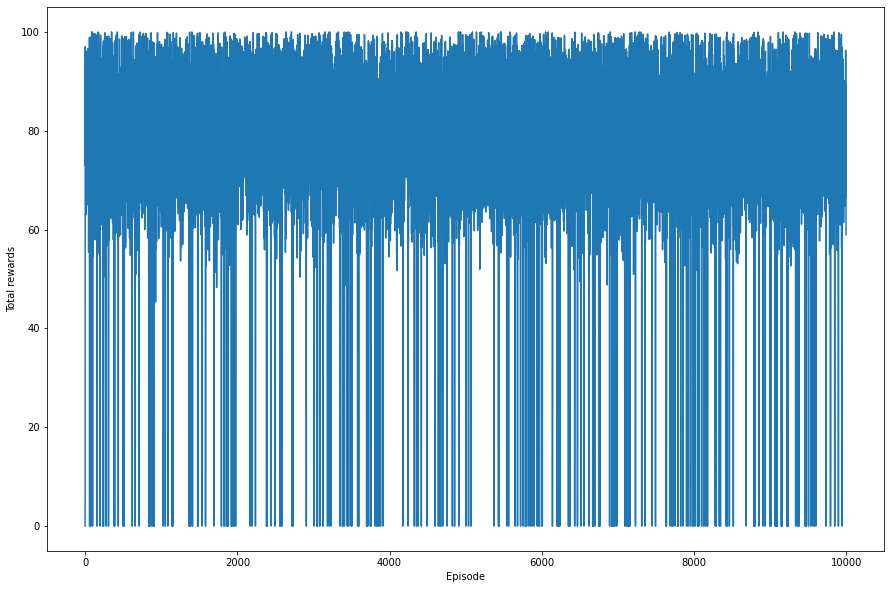

In [10]:
plt.figure(figsize=(15,10))
plt.xlabel("Episode")
plt.ylabel("Total rewards")
plt.plot(reward_list)

In [11]:
def moving_average(data,n):
    len_data=len(data)-n
    res_data=np.zeros(len_data)

    for i in range(len_data):
        res_data[i]=sum(data[i:i+n])/n
    return res_data

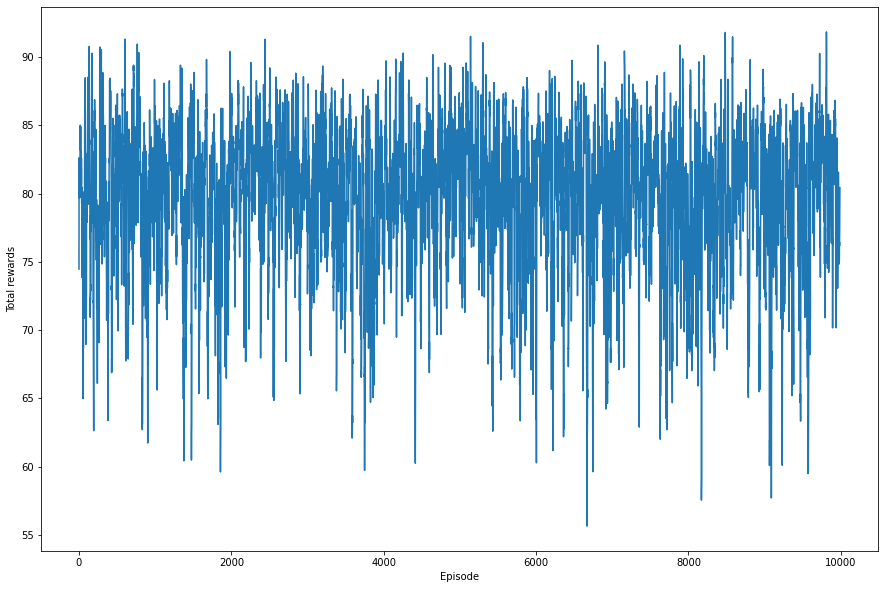

In [12]:
average_number=10
filtered_data=moving_average(reward_list,average_number)
plt.figure(figsize=(15,10))
plt.xlabel("Episode")
plt.ylabel("Total rewards")
plt.plot(filtered_data)

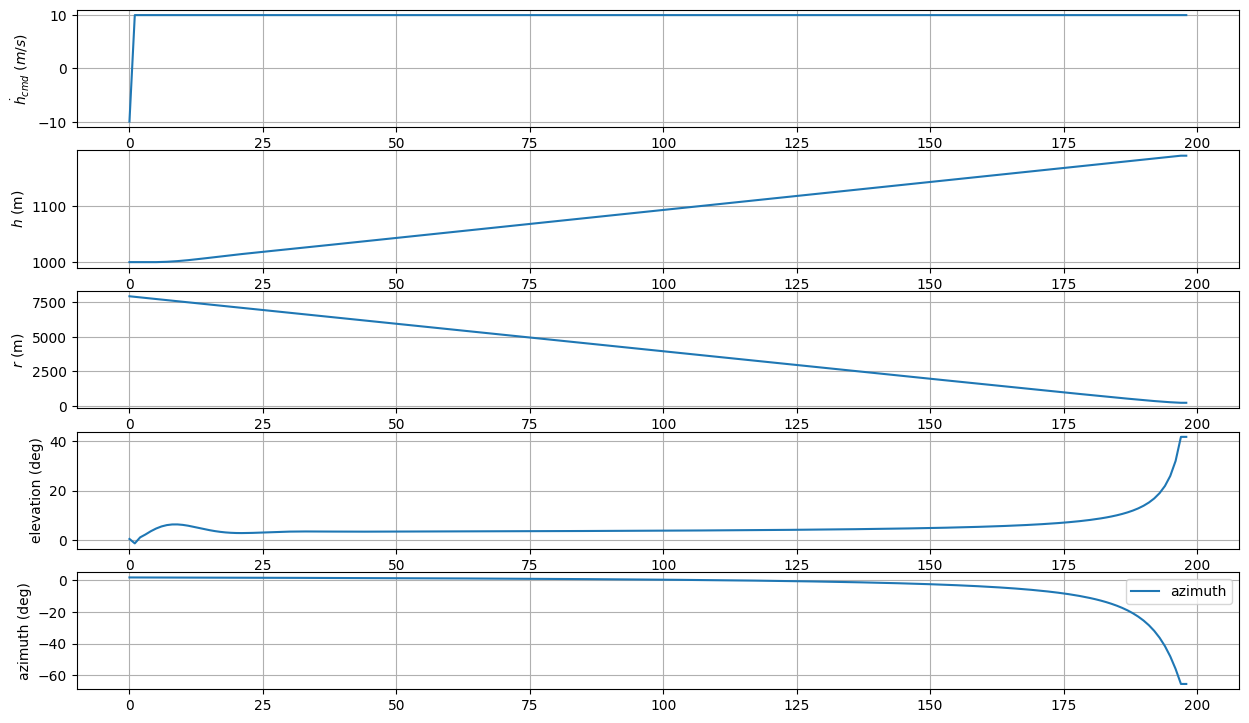

In [13]:
# plots
Deg2Rad = np.pi/180
Rad2Deg = 1/Deg2Rad

plt_res=total_res[99]


plt.figure(figsize=(15,9), dpi=100)

plt.subplot(511)
plt.plot(plt_res[:,0], label=r'$\dot{h}_{cmd}$')
plt.ylabel(r'$\dot{h}_{cmd}$ ($m/s$)'), plt.grid()

plt.subplot(512)
plt.plot(plt_res[:,10],label=r'$\{h}$')
plt.ylabel(r'$h$ (m)'), plt.grid()

plt.subplot(513)
plt.plot(plt_res[:,1],label=r'$\{r}$')
plt.ylabel(r'$r$ (m)'), plt.grid()

plt.subplot(514)
plt.plot(plt_res[:,2]*Rad2Deg, label='elevation')
plt.ylabel('elevation (deg)'), plt.grid()

plt.subplot(515)
plt.plot(plt_res[:,3]*Rad2Deg, label='azimuth')
plt.ylabel('azimuth (deg)'), plt.grid()

plt.legend()
plt.show()

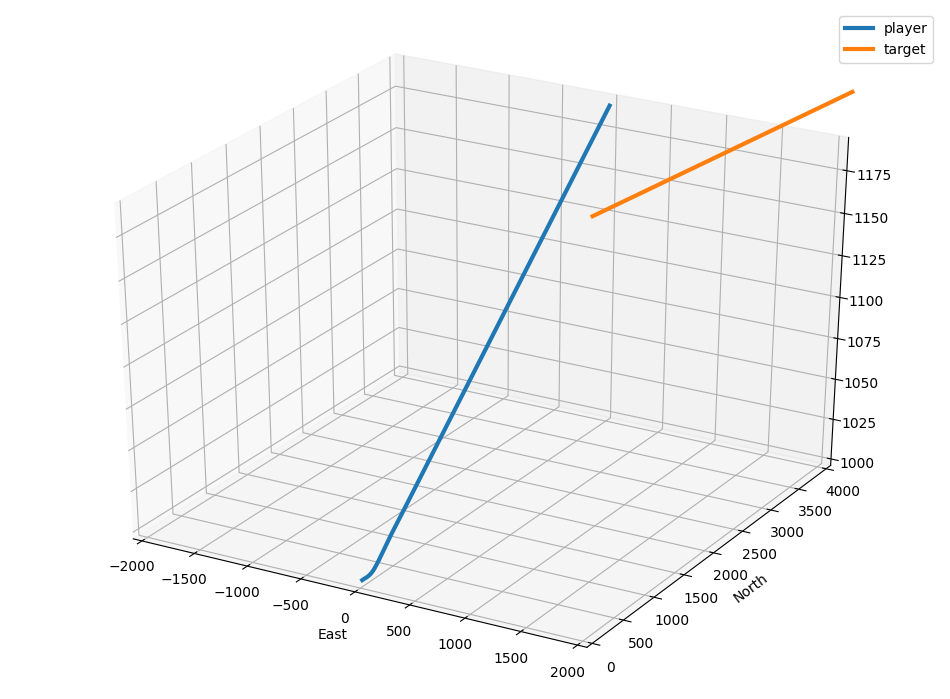

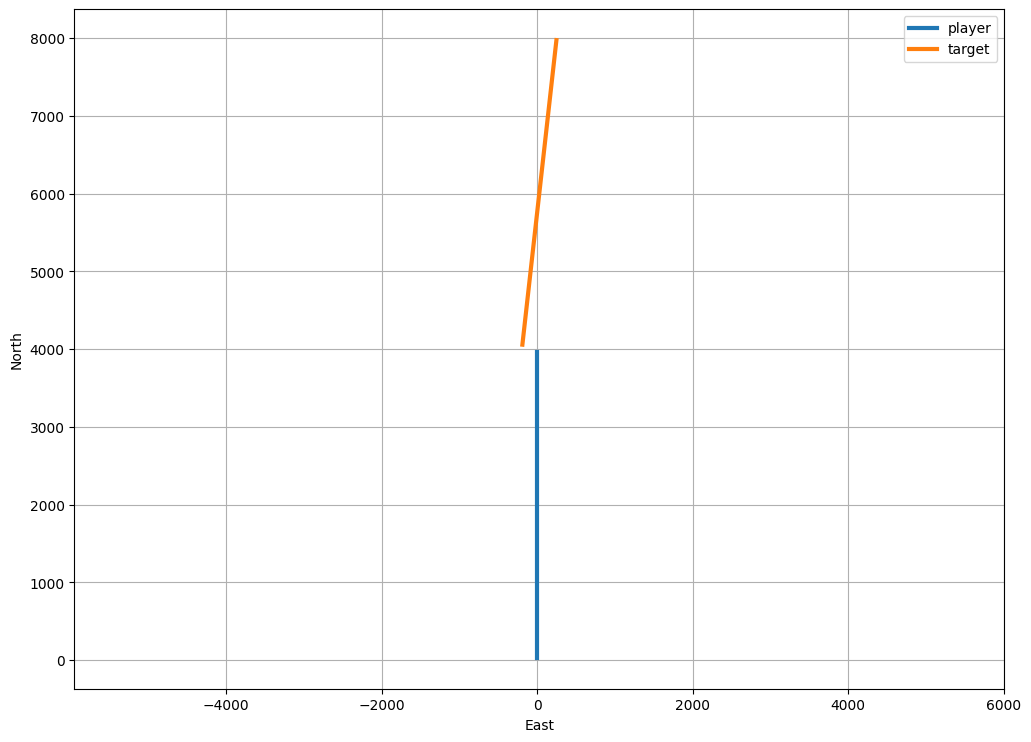

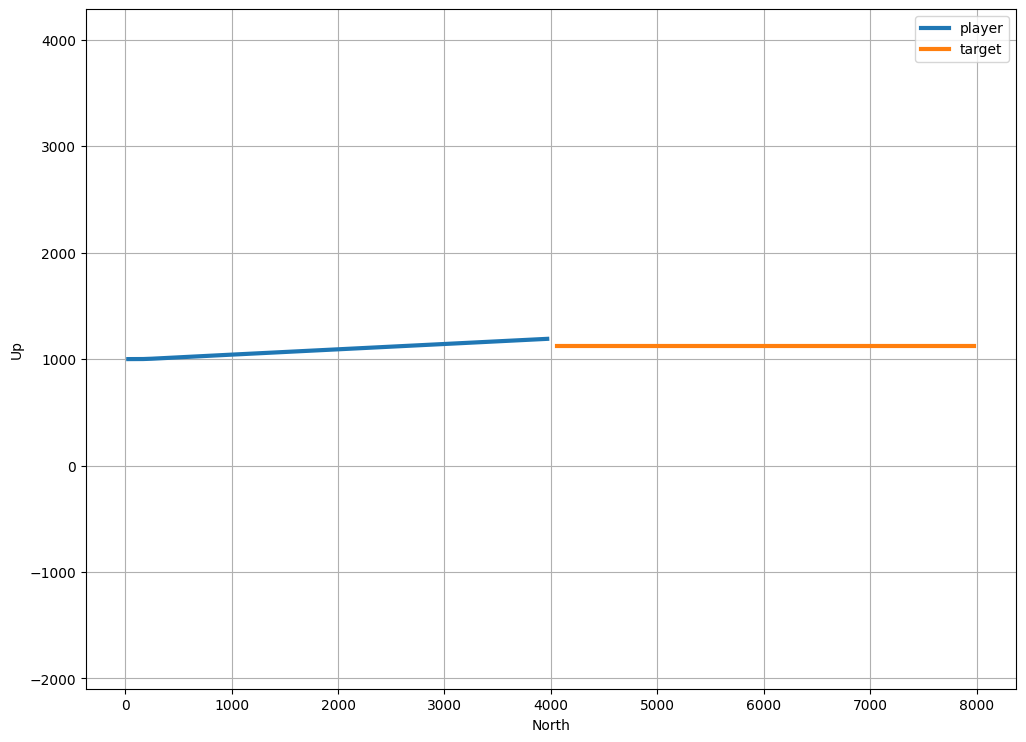

In [14]:
from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(12,9), dpi=100)
plt.gca(projection='3d')
plt.plot(plt_res[:,5], plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.xlim(-2000,2000)
plt.ylim(0,4000)
plt.legend()
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,5], plt_res[:,4], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('North')
plt.ylabel('Up')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

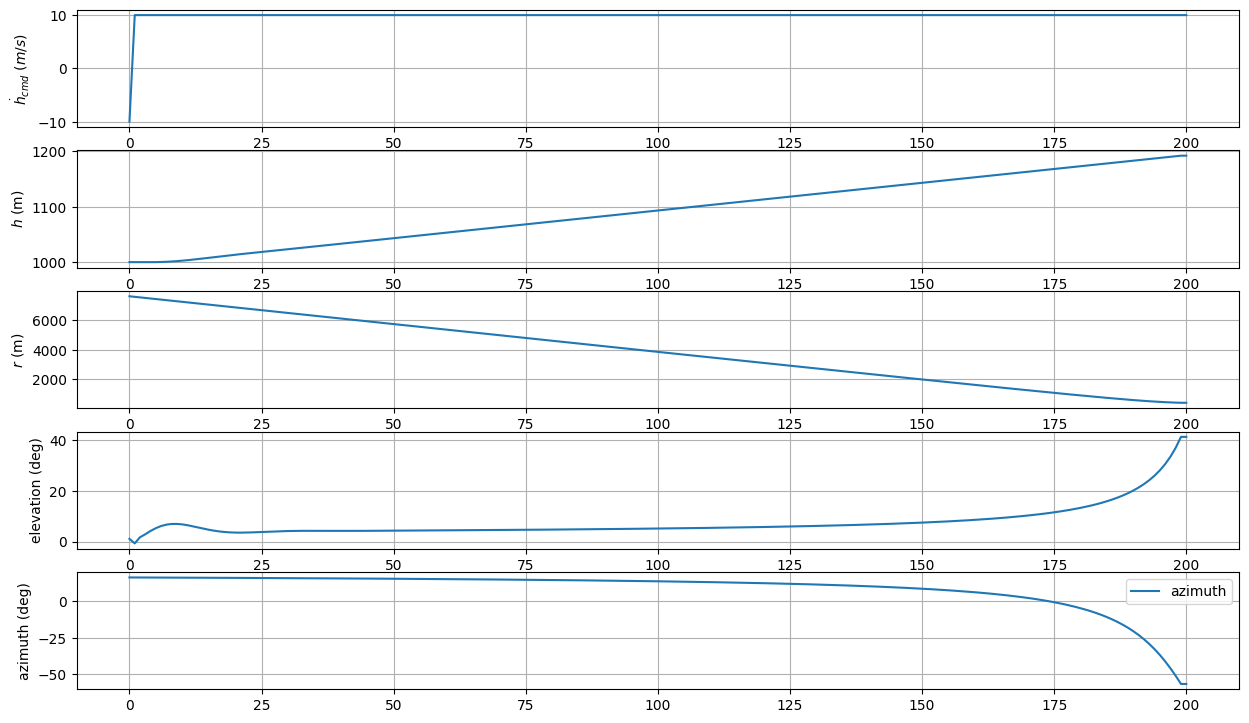

In [16]:
# plots
Deg2Rad = np.pi/180
Rad2Deg = 1/Deg2Rad

plt_res=total_res[9999]


plt.figure(figsize=(15,9), dpi=100)

plt.subplot(511)
plt.plot(plt_res[:,0], label=r'$\dot{h}_{cmd}$')
plt.ylabel(r'$\dot{h}_{cmd}$ ($m/s$)'), plt.grid()

plt.subplot(512)
plt.plot(plt_res[:,10],label=r'$\{h}$')
plt.ylabel(r'$h$ (m)'), plt.grid()

plt.subplot(513)
plt.plot(plt_res[:,1],label=r'$\{r}$')
plt.ylabel(r'$r$ (m)'), plt.grid()

plt.subplot(514)
plt.plot(plt_res[:,2]*Rad2Deg, label='elevation')
plt.ylabel('elevation (deg)'), plt.grid()

plt.subplot(515)
plt.plot(plt_res[:,3]*Rad2Deg, label='azimuth')
plt.ylabel('azimuth (deg)'), plt.grid()

plt.legend()
plt.show()

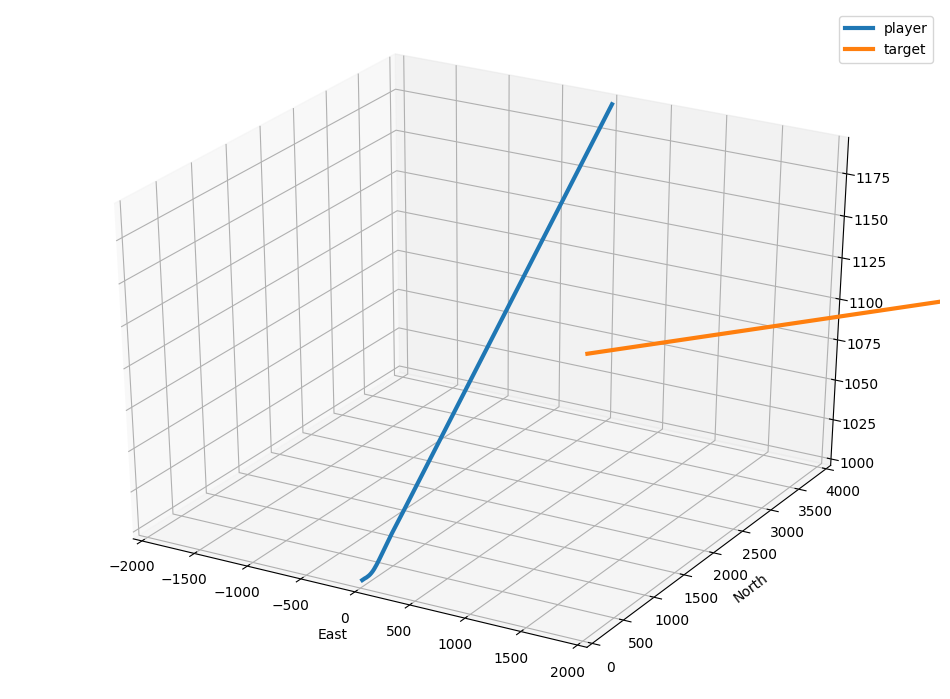

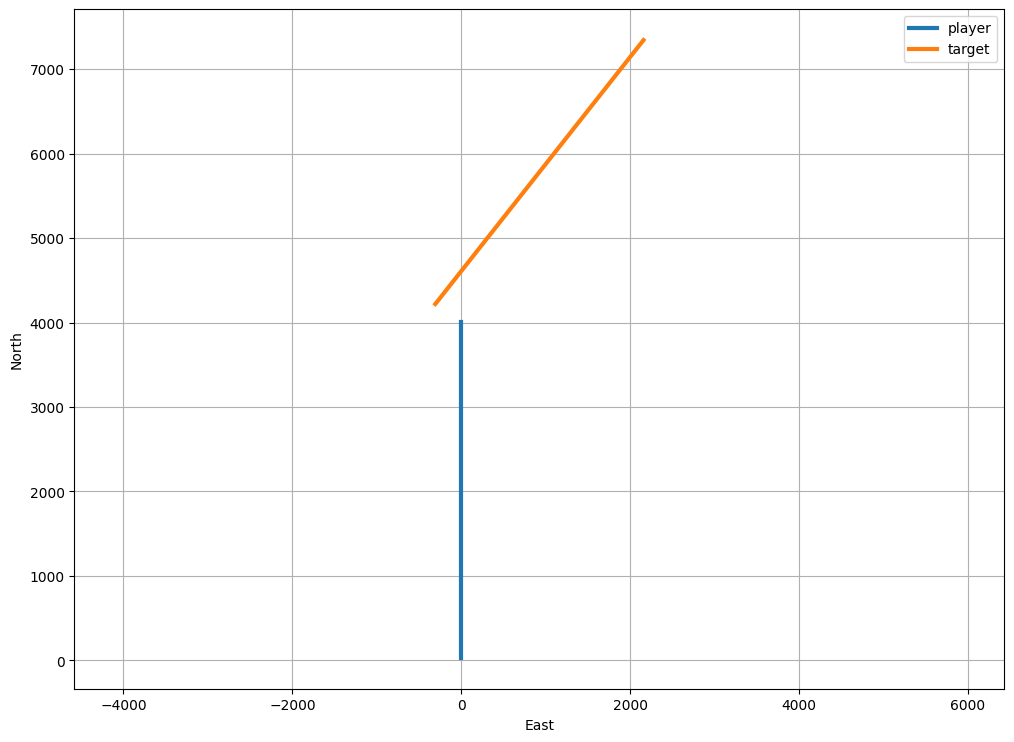

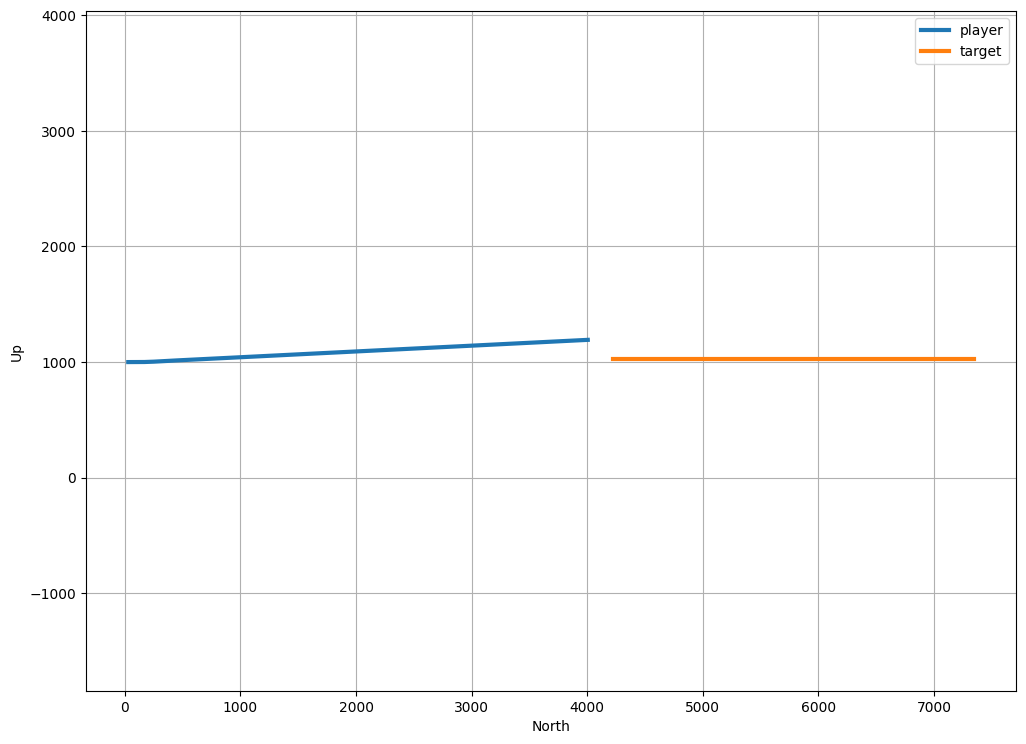

In [17]:
from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(12,9), dpi=100)
plt.gca(projection='3d')
plt.plot(plt_res[:,5], plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.xlim(-2000,2000)
plt.ylim(0,4000)
plt.legend()
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,5], plt_res[:,4], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('North')
plt.ylabel('Up')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

In [18]:
min(plt_res[:,10])

999.8704